# Keras - Quantization aware training



# Install TensorFlow Model optimization and TensorFlow nightly

In [ ]:
!pip uninstall -y tensorflow tensorflow-gpu
!pip install -q tf-nightly-gpu
!pip install -q tensorflow-model-optimization

Uninstalling tensorflow-2.2.0rc3:
  Successfully uninstalled tensorflow-2.2.0rc3
     |████████████████████████████████| 519.0MB 33kB/s 
     |████████████████████████████████| 3.0MB 43.3MB/s 
     |████████████████████████████████| 460kB 39.5MB/s 
     |████████████████████████████████| 174kB 5.8MB/s 
     |████████████████████████████████| 296kB 10.7MB/s 


Check version.

In [ ]:
!pip show tf-nightly-gpu

Name: tf-nightly-gpu
Version: 2.2.0.dev20200420
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: grpcio, protobuf, wheel, scipy, google-pasta, tb-nightly, termcolor, numpy, wrapt, tf-estimator-nightly, six, astunparse, keras-preprocessing, gast, h5py, opt-einsum, absl-py
Required-by: 


In [ ]:
!pip show tensorflow-model-optimization

Name: tensorflow-model-optimization
Version: 0.3.0
Summary: A suite of tools that users, both novice and advanced can use to optimize machine learning models for deployment and execution.
Home-page: https://github.com/tensorflow/model-optimization
Author: Google LLC
Author-email: no-reply@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: dm-tree, six, numpy
Required-by: 


Show GPU info.

In [ ]:
!nvidia-smi

Tue Apr 21 03:54:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import

In [ ]:
import sys
import os
import datetime
import time

import numpy as np

if sys.version_info.major >= 3:
    import pathlib
else:
    import pathlib2 as pathlib

import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow_model_optimization as tfmo

# Prepare the dataset

In [ ]:
splits = ("train[:80%]", "train[:10%]", "train[:10%]")

In [ ]:
# For tf_flowers
(raw_train, raw_validation, raw_test), info = tfds.load(name="tf_flowers",
                                                        with_info=True,
                                                        split=list(splits),
                                                        as_supervised=True)

# For cats vs dogs
# (raw_train, raw_validation, raw_test), info = tfds.load(name="cats_vs_dogs",
#                                                         with_info=True,
#                                                         split=list(splits),
#                                                         as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


Show datasets info

In [ ]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [ ]:
total_num_examples = info.splits['train'].num_examples

temp_num = total_num_examples - (total_num_examples % 100)
num_train = int(temp_num * 0.8 + (70 - 14))
num_val =  int(temp_num * 0.1 + 7)
num_test = int(temp_num * 0.1 + 7)

print('num train:', num_train)
print('num val  :', num_val)
print('num test :', num_test)

num train: 2936
num val  : 367
num test : 367


In [ ]:
IMG_SIZE = 224
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32

## Data augumentation


In [ ]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # image = (image/127.5) - 1

    # Resize the image if required
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

## Input format

In [ ]:
def augment_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.1, upper=0.6)

  return image, label

In [ ]:
train = train.map(augment_data)

In [ ]:
train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation = validation.batch(BATCH_SIZE)
test = test.batch(1)

# (Optional) prefetch will enable the input pipeline to asynchronously fetch batches while
# your model is training.
train = train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(train)
print(validation)
print(test)

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


## Display train image

In [ ]:
# Get the function which converts label indices to string
get_label_name = info.features['label'].int2str

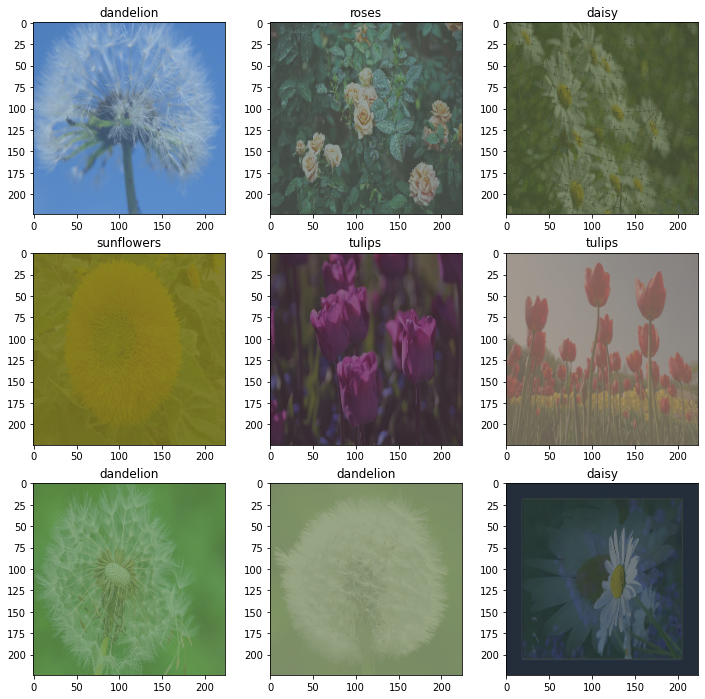

In [ ]:
plt.figure(figsize=(12,12)) 

for batch in train.take(1):
  for i in range(9):
    image, label = batch[0][i], batch[1][i]
    plt.subplot(3, 3, i+1)
    plt.imshow(image.numpy())
    plt.title(get_label_name(label.numpy()))
    plt.grid(False)    

# Train model

## Build model

In [ ]:
def setup_cnn_model():
  # extract image features by convolution and max pooling layers
  inputs = tf.keras.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
  x = tf.keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu")(inputs)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  # classify the class by fully-connected layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x)
  x = tf.keras.layers.Dense(info.features['label'].num_classes)(x)
  x = tf.keras.layers.Activation("softmax")(x)
  model_functional = tf.keras.Model(inputs=inputs, outputs=x)

  return model_functional

In [ ]:
def setup_mobilenet_v2_model():
  base_model = MobileNetV2(include_top=False,
                           weights='imagenet',
                           pooling='avg',
                           input_shape=(IMG_SIZE, IMG_SIZE, 3))
  x = base_model.output
  x = tf.keras.layers.Dense(info.features['label'].num_classes, activation="softmax")(x)
  model_functional = tf.keras.Model(inputs=base_model.input, outputs=x)

  return model_functional

In [ ]:
model = setup_mobilenet_v2_model()

model.trainable = True

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

## Training (Not QAT)

In [ ]:
steps_per_epoch = round(num_train) // BATCH_SIZE
validation_steps = round(num_val) // BATCH_SIZE

In [ ]:
history = model.fit(train.repeat(),
                    epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation.repeat(),
                    validation_steps=validation_steps)

Epoch 1/10
 3/91 [..............................] - ETA: 22s - loss: 1.5449 - accuracy: 0.3542WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226328). Check your callbacks.


 4/91 [>.............................] - ETA: 24s - loss: 1.5275 - accuracy: 0.3750WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227254). Check your callbacks.


 5/91 [>.............................] - ETA: 25s - loss: 1.4803 - accuracy: 0.3875WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226328). Check your callbacks.


 6/91 [>.............................] - ETA: 26s - loss: 1.3868 - accuracy: 0.4219WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227254). Check your callbacks.


 7/91 [=>............................] - ETA: 26s - loss: 1.3184 - accuracy: 0.4598WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226328). Check your callbacks.


 8/91 [=>............................] - ETA: 27s - loss: 1.2629 - accuracy: 0.4922WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227254). Check your callbacks.


 9/91 [=>............................] - ETA: 27s - loss: 1.2278 - accuracy: 0.5208WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228179). Check your callbacks.


10/91 [==>...........................] - ETA: 26s - loss: 1.1732 - accuracy: 0.5500WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227254). Check your callbacks.


11/91 [==>...........................] - ETA: 26s - loss: 1.1316 - accuracy: 0.5597WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228912). Check your callbacks.


12/91 [==>...........................] - ETA: 26s - loss: 1.1039 - accuracy: 0.5703WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227254). Check your callbacks.


13/91 [===>..........................] - ETA: 26s - loss: 1.0648 - accuracy: 0.5889WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224564). Check your callbacks.


14/91 [===>..........................] - ETA: 26s - loss: 1.0358 - accuracy: 0.6004WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225297). Check your callbacks.


15/91 [===>..........................] - ETA: 26s - loss: 1.0035 - accuracy: 0.6167WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224932). Check your callbacks.


16/91 [====>.........................] - ETA: 25s - loss: 0.9806 - accuracy: 0.6211WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.221404). Check your callbacks.


17/91 [====>.........................] - ETA: 25s - loss: 0.9602 - accuracy: 0.6342WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225884). Check your callbacks.


18/91 [====>.........................] - ETA: 25s - loss: 0.9364 - accuracy: 0.6458WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.221004). Check your callbacks.


19/91 [=====>........................] - ETA: 25s - loss: 0.9162 - accuracy: 0.6530WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.221004). Check your callbacks.


20/91 [=====>........................] - ETA: 24s - loss: 0.9089 - accuracy: 0.6578WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.221004). Check your callbacks.


21/91 [=====>........................] - ETA: 24s - loss: 0.8900 - accuracy: 0.6667WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.220688). Check your callbacks.


22/91 [======>.......................] - ETA: 24s - loss: 0.8770 - accuracy: 0.6719WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.221045). Check your callbacks.


23/91 [======>.......................] - ETA: 23s - loss: 0.8552 - accuracy: 0.6807WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.221911). Check your callbacks.


24/91 [======>.......................] - ETA: 23s - loss: 0.8371 - accuracy: 0.6888WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.221911). Check your callbacks.


25/91 [=======>......................] - ETA: 23s - loss: 0.8205 - accuracy: 0.6963WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.222273). Check your callbacks.


26/91 [=======>......................] - ETA: 22s - loss: 0.8051 - accuracy: 0.7019WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.222908). Check your callbacks.


27/91 [=======>......................] - ETA: 22s - loss: 0.7903 - accuracy: 0.7083WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.222908). Check your callbacks.


28/91 [========>.....................] - ETA: 22s - loss: 0.7801 - accuracy: 0.7121WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224116). Check your callbacks.


29/91 [========>.....................] - ETA: 22s - loss: 0.7761 - accuracy: 0.7155WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225475). Check your callbacks.


30/91 [========>.....................] - ETA: 21s - loss: 0.7681 - accuracy: 0.7177WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227099). Check your callbacks.


31/91 [=========>....................] - ETA: 21s - loss: 0.7590 - accuracy: 0.7208WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227099). Check your callbacks.


32/91 [=========>....................] - ETA: 21s - loss: 0.7480 - accuracy: 0.7256WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227099). Check your callbacks.


33/91 [=========>....................] - ETA: 20s - loss: 0.7373 - accuracy: 0.7292WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227099). Check your callbacks.


34/91 [==========>...................] - ETA: 20s - loss: 0.7269 - accuracy: 0.7335WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227099). Check your callbacks.


35/91 [==========>...................] - ETA: 20s - loss: 0.7183 - accuracy: 0.7375WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227816). Check your callbacks.


36/91 [==========>...................] - ETA: 19s - loss: 0.7113 - accuracy: 0.7413WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230248). Check your callbacks.


37/91 [===========>..................] - ETA: 19s - loss: 0.6988 - accuracy: 0.7466WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232141). Check your callbacks.


38/91 [===========>..................] - ETA: 19s - loss: 0.6862 - accuracy: 0.7525WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229733). Check your callbacks.


39/91 [===========>..................] - ETA: 18s - loss: 0.6822 - accuracy: 0.7540WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227301). Check your callbacks.


40/91 [============>.................] - ETA: 18s - loss: 0.6765 - accuracy: 0.7563WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229733). Check your callbacks.


41/91 [============>.................] - ETA: 17s - loss: 0.6692 - accuracy: 0.7591WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232141). Check your callbacks.


42/91 [============>.................] - ETA: 17s - loss: 0.6678 - accuracy: 0.7597WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232605). Check your callbacks.


43/91 [=============>................] - ETA: 17s - loss: 0.6601 - accuracy: 0.7624WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232605). Check your callbacks.


44/91 [=============>................] - ETA: 16s - loss: 0.6579 - accuracy: 0.7635WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232605). Check your callbacks.


45/91 [=============>................] - ETA: 16s - loss: 0.6525 - accuracy: 0.7660WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232605). Check your callbacks.


46/91 [==============>...............] - ETA: 16s - loss: 0.6444 - accuracy: 0.7697WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233156). Check your callbacks.


47/91 [==============>...............] - ETA: 15s - loss: 0.6410 - accuracy: 0.7699WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233343). Check your callbacks.


48/91 [==============>...............] - ETA: 15s - loss: 0.6388 - accuracy: 0.7702WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234424). Check your callbacks.


49/91 [===============>..............] - ETA: 15s - loss: 0.6344 - accuracy: 0.7723WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234424). Check your callbacks.


50/91 [===============>..............] - ETA: 14s - loss: 0.6344 - accuracy: 0.7738WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233343). Check your callbacks.


51/91 [===============>..............] - ETA: 14s - loss: 0.6276 - accuracy: 0.7770WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231653). Check your callbacks.


52/91 [================>.............] - ETA: 14s - loss: 0.6302 - accuracy: 0.7770WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228384). Check your callbacks.


53/91 [================>.............] - ETA: 13s - loss: 0.6239 - accuracy: 0.7795WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228796). Check your callbacks.


54/91 [================>.............] - ETA: 13s - loss: 0.6190 - accuracy: 0.7807WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228796). Check your callbacks.


55/91 [=================>............] - ETA: 13s - loss: 0.6116 - accuracy: 0.7841WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228796). Check your callbacks.


56/91 [=================>............] - ETA: 12s - loss: 0.6064 - accuracy: 0.7852WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227659). Check your callbacks.


57/91 [=================>............] - ETA: 12s - loss: 0.6073 - accuracy: 0.7856WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227659). Check your callbacks.


58/91 [==================>...........] - ETA: 12s - loss: 0.6009 - accuracy: 0.7883WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227659). Check your callbacks.


59/91 [==================>...........] - ETA: 11s - loss: 0.5977 - accuracy: 0.7892WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228796). Check your callbacks.


60/91 [==================>...........] - ETA: 11s - loss: 0.5930 - accuracy: 0.7896WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227404). Check your callbacks.


61/91 [===================>..........] - ETA: 10s - loss: 0.5901 - accuracy: 0.7910WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231835). Check your callbacks.


62/91 [===================>..........] - ETA: 10s - loss: 0.5857 - accuracy: 0.7923WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231835). Check your callbacks.


63/91 [===================>..........] - ETA: 10s - loss: 0.5835 - accuracy: 0.7932WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232865). Check your callbacks.


64/91 [====================>.........] - ETA: 9s - loss: 0.5834 - accuracy: 0.7930 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227851). Check your callbacks.


65/91 [====================>.........] - ETA: 9s - loss: 0.5837 - accuracy: 0.7928WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230536). Check your callbacks.


66/91 [====================>.........] - ETA: 9s - loss: 0.5826 - accuracy: 0.7936WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233270). Check your callbacks.


67/91 [=====================>........] - ETA: 8s - loss: 0.5818 - accuracy: 0.7943WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233270). Check your callbacks.


68/91 [=====================>........] - ETA: 8s - loss: 0.5785 - accuracy: 0.7960WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230536). Check your callbacks.


69/91 [=====================>........] - ETA: 8s - loss: 0.5761 - accuracy: 0.7971WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228898). Check your callbacks.


70/91 [======================>.......] - ETA: 7s - loss: 0.5717 - accuracy: 0.7991WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230536). Check your callbacks.


71/91 [======================>.......] - ETA: 7s - loss: 0.5671 - accuracy: 0.8006WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228898). Check your callbacks.


72/91 [======================>.......] - ETA: 6s - loss: 0.5623 - accuracy: 0.8025WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230536). Check your callbacks.


73/91 [=======================>......] - ETA: 6s - loss: 0.5563 - accuracy: 0.8048WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229303). Check your callbacks.


74/91 [=======================>......] - ETA: 6s - loss: 0.5572 - accuracy: 0.8045WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231565). Check your callbacks.


75/91 [=======================>......] - ETA: 5s - loss: 0.5546 - accuracy: 0.8050WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229927). Check your callbacks.


76/91 [========================>.....] - ETA: 5s - loss: 0.5508 - accuracy: 0.8067WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229927). Check your callbacks.


77/91 [========================>.....] - ETA: 5s - loss: 0.5474 - accuracy: 0.8076WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226735). Check your callbacks.


78/91 [========================>.....] - ETA: 4s - loss: 0.5434 - accuracy: 0.8089WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228457). Check your callbacks.


79/91 [=========================>....] - ETA: 4s - loss: 0.5394 - accuracy: 0.8101WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230719). Check your callbacks.


80/91 [=========================>....] - ETA: 4s - loss: 0.5435 - accuracy: 0.8098WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227527). Check your callbacks.


81/91 [=========================>....] - ETA: 3s - loss: 0.5400 - accuracy: 0.8110WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229043). Check your callbacks.


82/91 [==========================>...] - ETA: 3s - loss: 0.5381 - accuracy: 0.8114WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226702). Check your callbacks.


83/91 [==========================>...] - ETA: 2s - loss: 0.5352 - accuracy: 0.8129WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229043). Check your callbacks.


84/91 [==========================>...] - ETA: 2s - loss: 0.5340 - accuracy: 0.8132WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229043). Check your callbacks.


85/91 [===========================>..] - ETA: 2s - loss: 0.5320 - accuracy: 0.8136WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231593). Check your callbacks.


86/91 [===========================>..] - ETA: 1s - loss: 0.5312 - accuracy: 0.8132WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230703). Check your callbacks.


87/91 [===========================>..] - ETA: 1s - loss: 0.5309 - accuracy: 0.8132WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230703). Check your callbacks.


88/91 [============================>.] - ETA: 1s - loss: 0.5317 - accuracy: 0.8129WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230497). Check your callbacks.


89/91 [============================>.] - ETA: 0s - loss: 0.5290 - accuracy: 0.8139WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227925). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.5259 - accuracy: 0.8153WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228898). Check your callbacks.


91/91 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.8159WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230487). Check your callbacks.


91/91 [==============================] - 35s 386ms/step - loss: 0.5230 - accuracy: 0.8159 - val_loss: 0.4767 - val_accuracy: 0.8381
Epoch 2/10
 3/91 [..............................] - ETA: 1:42 - loss: 0.2024 - accuracy: 0.9545WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230035). Check your callbacks.


 4/91 [>.............................] - ETA: 1:24 - loss: 0.2130 - accuracy: 0.9500WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225674). Check your callbacks.


 5/91 [>.............................] - ETA: 1:14 - loss: 0.1954 - accuracy: 0.9474WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230035). Check your callbacks.


 6/91 [>.............................] - ETA: 1:07 - loss: 0.1846 - accuracy: 0.9511WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228831). Check your callbacks.


 7/91 [=>............................] - ETA: 1:02 - loss: 0.1732 - accuracy: 0.9537WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227627). Check your callbacks.


 8/91 [=>............................] - ETA: 57s - loss: 0.1803 - accuracy: 0.9516 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228831). Check your callbacks.


 9/91 [=>............................] - ETA: 54s - loss: 0.1802 - accuracy: 0.9500WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230035). Check your callbacks.


10/91 [==>...........................] - ETA: 52s - loss: 0.2131 - accuracy: 0.9391WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229811). Check your callbacks.


11/91 [==>...........................] - ETA: 49s - loss: 0.2114 - accuracy: 0.9390WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232429). Check your callbacks.


12/91 [==>...........................] - ETA: 48s - loss: 0.2111 - accuracy: 0.9362WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230799). Check your callbacks.


13/91 [===>..........................] - ETA: 46s - loss: 0.2307 - accuracy: 0.9265WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230575). Check your callbacks.


14/91 [===>..........................] - ETA: 44s - loss: 0.2280 - accuracy: 0.9295WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231901). Check your callbacks.


15/91 [===>..........................] - ETA: 43s - loss: 0.2319 - accuracy: 0.9237WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231901). Check your callbacks.


16/91 [====>.........................] - ETA: 42s - loss: 0.2262 - accuracy: 0.9266WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233904). Check your callbacks.


17/91 [====>.........................] - ETA: 41s - loss: 0.2231 - accuracy: 0.9272WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235220). Check your callbacks.


18/91 [====>.........................] - ETA: 40s - loss: 0.2196 - accuracy: 0.9278WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233556). Check your callbacks.


19/91 [=====>........................] - ETA: 39s - loss: 0.2342 - accuracy: 0.9183WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233556). Check your callbacks.


20/91 [=====>........................] - ETA: 38s - loss: 0.2304 - accuracy: 0.9209WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233556). Check your callbacks.


21/91 [=====>........................] - ETA: 37s - loss: 0.2259 - accuracy: 0.9232WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231901). Check your callbacks.


22/91 [======>.......................] - ETA: 36s - loss: 0.2240 - accuracy: 0.9224WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229992). Check your callbacks.


23/91 [======>.......................] - ETA: 35s - loss: 0.2229 - accuracy: 0.9231WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233556). Check your callbacks.


24/91 [======>.......................] - ETA: 34s - loss: 0.2177 - accuracy: 0.9263WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230156). Check your callbacks.


25/91 [=======>......................] - ETA: 34s - loss: 0.2167 - accuracy: 0.9280WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229707). Check your callbacks.


26/91 [=======>......................] - ETA: 33s - loss: 0.2195 - accuracy: 0.9260WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229082). Check your callbacks.


27/91 [=======>......................] - ETA: 32s - loss: 0.2140 - accuracy: 0.9276WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229082). Check your callbacks.


28/91 [========>.....................] - ETA: 31s - loss: 0.2125 - accuracy: 0.9268WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229414). Check your callbacks.


29/91 [========>.....................] - ETA: 31s - loss: 0.2128 - accuracy: 0.9261WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229414). Check your callbacks.


30/91 [========>.....................] - ETA: 30s - loss: 0.2137 - accuracy: 0.9265WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232998). Check your callbacks.


31/91 [=========>....................] - ETA: 29s - loss: 0.2105 - accuracy: 0.9278WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233624). Check your callbacks.


32/91 [=========>....................] - ETA: 29s - loss: 0.2128 - accuracy: 0.9262WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233624). Check your callbacks.


33/91 [=========>....................] - ETA: 28s - loss: 0.2102 - accuracy: 0.9265WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232998). Check your callbacks.


34/91 [==========>...................] - ETA: 27s - loss: 0.2078 - accuracy: 0.9287WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233292). Check your callbacks.


35/91 [==========>...................] - ETA: 27s - loss: 0.2052 - accuracy: 0.9299WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233292). Check your callbacks.


36/91 [==========>...................] - ETA: 26s - loss: 0.2057 - accuracy: 0.9292WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233292). Check your callbacks.


37/91 [===========>..................] - ETA: 26s - loss: 0.2045 - accuracy: 0.9286WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233292). Check your callbacks.


38/91 [===========>..................] - ETA: 25s - loss: 0.2018 - accuracy: 0.9296WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233814). Check your callbacks.


39/91 [===========>..................] - ETA: 25s - loss: 0.2107 - accuracy: 0.9282WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233814). Check your callbacks.


40/91 [============>.................] - ETA: 24s - loss: 0.2081 - accuracy: 0.9292WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233814). Check your callbacks.


41/91 [============>.................] - ETA: 23s - loss: 0.2069 - accuracy: 0.9294WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233814). Check your callbacks.


42/91 [============>.................] - ETA: 23s - loss: 0.2046 - accuracy: 0.9304WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233814). Check your callbacks.


43/91 [=============>................] - ETA: 22s - loss: 0.2051 - accuracy: 0.9298WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233814). Check your callbacks.


44/91 [=============>................] - ETA: 22s - loss: 0.2018 - accuracy: 0.9314WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231698). Check your callbacks.


45/91 [=============>................] - ETA: 21s - loss: 0.2023 - accuracy: 0.9309WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228637). Check your callbacks.


46/91 [==============>...............] - ETA: 21s - loss: 0.1997 - accuracy: 0.9324WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229320). Check your callbacks.


47/91 [==============>...............] - ETA: 20s - loss: 0.1999 - accuracy: 0.9318WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228637). Check your callbacks.


48/91 [==============>...............] - ETA: 20s - loss: 0.2016 - accuracy: 0.9313WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227876). Check your callbacks.


49/91 [===============>..............] - ETA: 19s - loss: 0.1995 - accuracy: 0.9327WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227876). Check your callbacks.


50/91 [===============>..............] - ETA: 19s - loss: 0.1972 - accuracy: 0.9340WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228477). Check your callbacks.


51/91 [===============>..............] - ETA: 18s - loss: 0.1968 - accuracy: 0.9335WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228477). Check your callbacks.


52/91 [================>.............] - ETA: 18s - loss: 0.1955 - accuracy: 0.9342WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228477). Check your callbacks.


53/91 [================>.............] - ETA: 17s - loss: 0.1943 - accuracy: 0.9342WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228160). Check your callbacks.


54/91 [================>.............] - ETA: 17s - loss: 0.1945 - accuracy: 0.9343WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226771). Check your callbacks.


55/91 [=================>............] - ETA: 16s - loss: 0.1925 - accuracy: 0.9355WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227371). Check your callbacks.


56/91 [=================>............] - ETA: 16s - loss: 0.1901 - accuracy: 0.9367WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226780). Check your callbacks.


57/91 [=================>............] - ETA: 15s - loss: 0.1883 - accuracy: 0.9372WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228169). Check your callbacks.


58/91 [==================>...........] - ETA: 15s - loss: 0.1878 - accuracy: 0.9367WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228710). Check your callbacks.


59/91 [==================>...........] - ETA: 14s - loss: 0.1869 - accuracy: 0.9367WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228710). Check your callbacks.


60/91 [==================>...........] - ETA: 14s - loss: 0.1889 - accuracy: 0.9346WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228118). Check your callbacks.


61/91 [===================>..........] - ETA: 13s - loss: 0.1880 - accuracy: 0.9342WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228118). Check your callbacks.


62/91 [===================>..........] - ETA: 13s - loss: 0.1870 - accuracy: 0.9342WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229691). Check your callbacks.


63/91 [===================>..........] - ETA: 12s - loss: 0.1848 - accuracy: 0.9353WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230876). Check your callbacks.


64/91 [====================>.........] - ETA: 12s - loss: 0.1849 - accuracy: 0.9348WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230876). Check your callbacks.


65/91 [====================>.........] - ETA: 11s - loss: 0.1848 - accuracy: 0.9344WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230364). Check your callbacks.


66/91 [====================>.........] - ETA: 11s - loss: 0.1859 - accuracy: 0.9344WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230876). Check your callbacks.


67/91 [=====================>........] - ETA: 10s - loss: 0.1844 - accuracy: 0.9354WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230364). Check your callbacks.


68/91 [=====================>........] - ETA: 10s - loss: 0.1842 - accuracy: 0.9354WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230364). Check your callbacks.


69/91 [=====================>........] - ETA: 9s - loss: 0.1839 - accuracy: 0.9359 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230364). Check your callbacks.


70/91 [======================>.......] - ETA: 9s - loss: 0.1820 - accuracy: 0.9364WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231440). Check your callbacks.


71/91 [======================>.......] - ETA: 8s - loss: 0.1824 - accuracy: 0.9364WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231440). Check your callbacks.


72/91 [======================>.......] - ETA: 8s - loss: 0.1805 - accuracy: 0.9373WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232816). Check your callbacks.


73/91 [=======================>......] - ETA: 8s - loss: 0.1803 - accuracy: 0.9369WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232816). Check your callbacks.


74/91 [=======================>......] - ETA: 7s - loss: 0.1793 - accuracy: 0.9373WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233339). Check your callbacks.


75/91 [=======================>......] - ETA: 7s - loss: 0.1801 - accuracy: 0.9369WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233339). Check your callbacks.


76/91 [========================>.....] - ETA: 6s - loss: 0.1794 - accuracy: 0.9373WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234520). Check your callbacks.


77/91 [========================>.....] - ETA: 6s - loss: 0.1788 - accuracy: 0.9377WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235764). Check your callbacks.


78/91 [========================>.....] - ETA: 5s - loss: 0.1791 - accuracy: 0.9373WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235764). Check your callbacks.


79/91 [=========================>....] - ETA: 5s - loss: 0.1797 - accuracy: 0.9373WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235764). Check your callbacks.


80/91 [=========================>....] - ETA: 4s - loss: 0.1795 - accuracy: 0.9373WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234719). Check your callbacks.


81/91 [=========================>....] - ETA: 4s - loss: 0.1776 - accuracy: 0.9381WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233339). Check your callbacks.


82/91 [==========================>...] - ETA: 3s - loss: 0.1775 - accuracy: 0.9381WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233146). Check your callbacks.


83/91 [==========================>...] - ETA: 3s - loss: 0.1785 - accuracy: 0.9373WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233146). Check your callbacks.


84/91 [==========================>...] - ETA: 3s - loss: 0.1790 - accuracy: 0.9369WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234526). Check your callbacks.


85/91 [===========================>..] - ETA: 2s - loss: 0.1800 - accuracy: 0.9366WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234858). Check your callbacks.


86/91 [===========================>..] - ETA: 2s - loss: 0.1811 - accuracy: 0.9362WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233420). Check your callbacks.


87/91 [===========================>..] - ETA: 1s - loss: 0.1808 - accuracy: 0.9362WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233420). Check your callbacks.


88/91 [============================>.] - ETA: 1s - loss: 0.1800 - accuracy: 0.9366WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233420). Check your callbacks.


89/91 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9366WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233420). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.1783 - accuracy: 0.9373WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233420). Check your callbacks.


91/91 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9370WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236543). Check your callbacks.


91/91 [==============================] - 40s 443ms/step - loss: 0.1819 - accuracy: 0.9370 - val_loss: 0.4514 - val_accuracy: 0.8551
Epoch 3/10
 1/91 [..............................] - ETA: 20s - loss: 0.1938 - accuracy: 0.9688WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228510). Check your callbacks.


 2/91 [..............................] - ETA: 22s - loss: 0.1630 - accuracy: 0.9643WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.205292). Check your callbacks.


 4/91 [>.............................] - ETA: 1:27 - loss: 0.1149 - accuracy: 0.9750WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225201). Check your callbacks.


 5/91 [>.............................] - ETA: 1:17 - loss: 0.1016 - accuracy: 0.9737WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228510). Check your callbacks.


 6/91 [>.............................] - ETA: 1:09 - loss: 0.0895 - accuracy: 0.9783WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228703). Check your callbacks.


 7/91 [=>............................] - ETA: 1:04 - loss: 0.0845 - accuracy: 0.9815WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228510). Check your callbacks.


 8/91 [=>............................] - ETA: 59s - loss: 0.0881 - accuracy: 0.9798 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225512). Check your callbacks.


 9/91 [=>............................] - ETA: 56s - loss: 0.0864 - accuracy: 0.9786WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227878). Check your callbacks.


10/91 [==>...........................] - ETA: 53s - loss: 0.0943 - accuracy: 0.9712WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226115). Check your callbacks.


11/91 [==>...........................] - ETA: 51s - loss: 0.0930 - accuracy: 0.9709WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226115). Check your callbacks.


12/91 [==>...........................] - ETA: 49s - loss: 0.0912 - accuracy: 0.9707WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228387). Check your callbacks.


13/91 [===>..........................] - ETA: 47s - loss: 0.0928 - accuracy: 0.9706WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228387). Check your callbacks.


14/91 [===>..........................] - ETA: 45s - loss: 0.0930 - accuracy: 0.9727WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228696). Check your callbacks.


15/91 [===>..........................] - ETA: 44s - loss: 0.0899 - accuracy: 0.9746WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228696). Check your callbacks.


16/91 [====>.........................] - ETA: 43s - loss: 0.0925 - accuracy: 0.9722WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229116). Check your callbacks.


17/91 [====>.........................] - ETA: 41s - loss: 0.0908 - accuracy: 0.9739WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229116). Check your callbacks.


18/91 [====>.........................] - ETA: 40s - loss: 0.0933 - accuracy: 0.9718WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230853). Check your callbacks.


19/91 [=====>........................] - ETA: 39s - loss: 0.0986 - accuracy: 0.9700WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231748). Check your callbacks.


20/91 [=====>........................] - ETA: 38s - loss: 0.0972 - accuracy: 0.9699WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231748). Check your callbacks.


21/91 [=====>........................] - ETA: 37s - loss: 0.0942 - accuracy: 0.9714WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230853). Check your callbacks.


22/91 [======>.......................] - ETA: 36s - loss: 0.0967 - accuracy: 0.9713WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228381). Check your callbacks.


23/91 [======>.......................] - ETA: 35s - loss: 0.0955 - accuracy: 0.9725WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228381). Check your callbacks.


24/91 [======>.......................] - ETA: 34s - loss: 0.1029 - accuracy: 0.9697WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228881). Check your callbacks.


25/91 [=======>......................] - ETA: 34s - loss: 0.1030 - accuracy: 0.9697WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228881). Check your callbacks.


26/91 [=======>......................] - ETA: 33s - loss: 0.1021 - accuracy: 0.9709WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228881). Check your callbacks.


27/91 [=======>......................] - ETA: 32s - loss: 0.1066 - accuracy: 0.9696WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228881). Check your callbacks.


28/91 [========>.....................] - ETA: 32s - loss: 0.1071 - accuracy: 0.9696WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226376). Check your callbacks.


29/91 [========>.....................] - ETA: 31s - loss: 0.1063 - accuracy: 0.9696WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226376). Check your callbacks.


30/91 [========>.....................] - ETA: 30s - loss: 0.1068 - accuracy: 0.9674WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226376). Check your callbacks.


31/91 [=========>....................] - ETA: 30s - loss: 0.1071 - accuracy: 0.9665WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226610). Check your callbacks.


32/91 [=========>....................] - ETA: 29s - loss: 0.1068 - accuracy: 0.9656WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231284). Check your callbacks.


33/91 [=========>....................] - ETA: 28s - loss: 0.1055 - accuracy: 0.9656WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231284). Check your callbacks.


34/91 [==========>...................] - ETA: 28s - loss: 0.1081 - accuracy: 0.9648WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231298). Check your callbacks.


35/91 [==========>...................] - ETA: 27s - loss: 0.1061 - accuracy: 0.9658WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231298). Check your callbacks.


36/91 [==========>...................] - ETA: 27s - loss: 0.1056 - accuracy: 0.9668WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225542). Check your callbacks.


37/91 [===========>..................] - ETA: 26s - loss: 0.1051 - accuracy: 0.9668WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225542). Check your callbacks.


38/91 [===========>..................] - ETA: 25s - loss: 0.1036 - accuracy: 0.9677WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229398). Check your callbacks.


39/91 [===========>..................] - ETA: 25s - loss: 0.1049 - accuracy: 0.9677WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225930). Check your callbacks.


40/91 [============>.................] - ETA: 24s - loss: 0.1052 - accuracy: 0.9670WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229398). Check your callbacks.


41/91 [============>.................] - ETA: 24s - loss: 0.1055 - accuracy: 0.9663WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230624). Check your callbacks.


42/91 [============>.................] - ETA: 23s - loss: 0.1060 - accuracy: 0.9656WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230624). Check your callbacks.


43/91 [=============>................] - ETA: 23s - loss: 0.1110 - accuracy: 0.9642WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232348). Check your callbacks.


44/91 [=============>................] - ETA: 22s - loss: 0.1089 - accuracy: 0.9650WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232348). Check your callbacks.


45/91 [=============>................] - ETA: 22s - loss: 0.1111 - accuracy: 0.9644WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230624). Check your callbacks.


46/91 [==============>...............] - ETA: 21s - loss: 0.1114 - accuracy: 0.9638WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230624). Check your callbacks.


47/91 [==============>...............] - ETA: 20s - loss: 0.1123 - accuracy: 0.9639WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230624). Check your callbacks.


48/91 [==============>...............] - ETA: 20s - loss: 0.1117 - accuracy: 0.9640WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229114). Check your callbacks.


49/91 [===============>..............] - ETA: 19s - loss: 0.1120 - accuracy: 0.9641WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231053). Check your callbacks.


50/91 [===============>..............] - ETA: 19s - loss: 0.1121 - accuracy: 0.9642WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229114). Check your callbacks.


51/91 [===============>..............] - ETA: 18s - loss: 0.1101 - accuracy: 0.9649WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228831). Check your callbacks.


52/91 [================>.............] - ETA: 18s - loss: 0.1090 - accuracy: 0.9650WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227599). Check your callbacks.


53/91 [================>.............] - ETA: 17s - loss: 0.1081 - accuracy: 0.9656WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227599). Check your callbacks.


54/91 [================>.............] - ETA: 17s - loss: 0.1078 - accuracy: 0.9663WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225516). Check your callbacks.


55/91 [=================>............] - ETA: 16s - loss: 0.1072 - accuracy: 0.9669WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225516). Check your callbacks.


56/91 [=================>............] - ETA: 16s - loss: 0.1069 - accuracy: 0.9669WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225516). Check your callbacks.


57/91 [=================>............] - ETA: 15s - loss: 0.1066 - accuracy: 0.9670WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227393). Check your callbacks.


58/91 [==================>...........] - ETA: 15s - loss: 0.1080 - accuracy: 0.9659WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227393). Check your callbacks.


59/91 [==================>...........] - ETA: 14s - loss: 0.1078 - accuracy: 0.9660WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225516). Check your callbacks.


60/91 [==================>...........] - ETA: 14s - loss: 0.1065 - accuracy: 0.9665WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225516). Check your callbacks.


61/91 [===================>..........] - ETA: 13s - loss: 0.1058 - accuracy: 0.9666WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224112). Check your callbacks.


62/91 [===================>..........] - ETA: 13s - loss: 0.1046 - accuracy: 0.9671WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.223500). Check your callbacks.


63/91 [===================>..........] - ETA: 12s - loss: 0.1049 - accuracy: 0.9671WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.223500). Check your callbacks.


64/91 [====================>.........] - ETA: 12s - loss: 0.1047 - accuracy: 0.9672WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225589). Check your callbacks.


65/91 [====================>.........] - ETA: 11s - loss: 0.1051 - accuracy: 0.9667WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225589). Check your callbacks.


66/91 [====================>.........] - ETA: 11s - loss: 0.1049 - accuracy: 0.9667WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227699). Check your callbacks.


67/91 [=====================>........] - ETA: 10s - loss: 0.1070 - accuracy: 0.9663WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226534). Check your callbacks.


68/91 [=====================>........] - ETA: 10s - loss: 0.1060 - accuracy: 0.9668WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226534). Check your callbacks.


69/91 [=====================>........] - ETA: 9s - loss: 0.1086 - accuracy: 0.9650 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226671). Check your callbacks.


70/91 [======================>.......] - ETA: 9s - loss: 0.1079 - accuracy: 0.9655WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227699). Check your callbacks.


71/91 [======================>.......] - ETA: 9s - loss: 0.1073 - accuracy: 0.9660WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227699). Check your callbacks.


72/91 [======================>.......] - ETA: 8s - loss: 0.1063 - accuracy: 0.9665WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227699). Check your callbacks.


73/91 [=======================>......] - ETA: 8s - loss: 0.1064 - accuracy: 0.9665WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227699). Check your callbacks.


74/91 [=======================>......] - ETA: 7s - loss: 0.1061 - accuracy: 0.9665WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228156). Check your callbacks.


75/91 [=======================>......] - ETA: 7s - loss: 0.1065 - accuracy: 0.9666WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226815). Check your callbacks.


76/91 [========================>.....] - ETA: 6s - loss: 0.1060 - accuracy: 0.9666WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227128). Check your callbacks.


77/91 [========================>.....] - ETA: 6s - loss: 0.1058 - accuracy: 0.9666WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232915). Check your callbacks.


78/91 [========================>.....] - ETA: 5s - loss: 0.1056 - accuracy: 0.9662WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232915). Check your callbacks.


79/91 [=========================>....] - ETA: 5s - loss: 0.1056 - accuracy: 0.9663WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232915). Check your callbacks.


80/91 [=========================>....] - ETA: 4s - loss: 0.1048 - accuracy: 0.9667WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228131). Check your callbacks.


81/91 [=========================>....] - ETA: 4s - loss: 0.1045 - accuracy: 0.9667WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228596). Check your callbacks.


82/91 [==========================>...] - ETA: 3s - loss: 0.1038 - accuracy: 0.9671WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228596). Check your callbacks.


83/91 [==========================>...] - ETA: 3s - loss: 0.1036 - accuracy: 0.9675WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228590). Check your callbacks.


84/91 [==========================>...] - ETA: 3s - loss: 0.1038 - accuracy: 0.9672WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228590). Check your callbacks.


85/91 [===========================>..] - ETA: 2s - loss: 0.1029 - accuracy: 0.9676WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228590). Check your callbacks.


86/91 [===========================>..] - ETA: 2s - loss: 0.1021 - accuracy: 0.9679WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228125). Check your callbacks.


87/91 [===========================>..] - ETA: 1s - loss: 0.1024 - accuracy: 0.9679WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228125). Check your callbacks.


88/91 [============================>.] - ETA: 1s - loss: 0.1016 - accuracy: 0.9683WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228050). Check your callbacks.


89/91 [============================>.] - ETA: 0s - loss: 0.1011 - accuracy: 0.9687WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228381). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.1006 - accuracy: 0.9687WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228381). Check your callbacks.


91/91 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9690WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227665). Check your callbacks.


91/91 [==============================] - 40s 444ms/step - loss: 0.0998 - accuracy: 0.9690 - val_loss: 0.3568 - val_accuracy: 0.8750
Epoch 4/10
 1/91 [..............................] - ETA: 20s - loss: 0.1909 - accuracy: 0.9062WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228187). Check your callbacks.


 2/91 [..............................] - ETA: 26s - loss: 0.1675 - accuracy: 0.9375WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237709). Check your callbacks.


 3/91 [..............................] - ETA: 25s - loss: 0.1464 - accuracy: 0.9318WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228187). Check your callbacks.


 5/91 [>.............................] - ETA: 1:15 - loss: 0.1090 - accuracy: 0.9539WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229240). Check your callbacks.


 6/91 [>.............................] - ETA: 1:08 - loss: 0.1020 - accuracy: 0.9565WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228813). Check your callbacks.


 7/91 [=>............................] - ETA: 1:03 - loss: 0.0933 - accuracy: 0.9630WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228385). Check your callbacks.


 8/91 [=>............................] - ETA: 59s - loss: 0.0868 - accuracy: 0.9677 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228286). Check your callbacks.


 9/91 [=>............................] - ETA: 55s - loss: 0.0856 - accuracy: 0.9643WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228385). Check your callbacks.


10/91 [==>...........................] - ETA: 52s - loss: 0.0791 - accuracy: 0.9679WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228678). Check your callbacks.


11/91 [==>...........................] - ETA: 50s - loss: 0.0759 - accuracy: 0.9709WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229105). Check your callbacks.


12/91 [==>...........................] - ETA: 48s - loss: 0.0719 - accuracy: 0.9734WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229105). Check your callbacks.


13/91 [===>..........................] - ETA: 46s - loss: 0.0745 - accuracy: 0.9730WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229105). Check your callbacks.


14/91 [===>..........................] - ETA: 44s - loss: 0.0713 - accuracy: 0.9750WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229105). Check your callbacks.


15/91 [===>..........................] - ETA: 43s - loss: 0.0692 - accuracy: 0.9746WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230032). Check your callbacks.


16/91 [====>.........................] - ETA: 42s - loss: 0.0679 - accuracy: 0.9762WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233207). Check your callbacks.


17/91 [====>.........................] - ETA: 40s - loss: 0.0654 - accuracy: 0.9776WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233207). Check your callbacks.


18/91 [====>.........................] - ETA: 39s - loss: 0.0714 - accuracy: 0.9754WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235654). Check your callbacks.


19/91 [=====>........................] - ETA: 38s - loss: 0.0691 - accuracy: 0.9767WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233207). Check your callbacks.


20/91 [=====>........................] - ETA: 37s - loss: 0.0709 - accuracy: 0.9747WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233207). Check your callbacks.


21/91 [=====>........................] - ETA: 37s - loss: 0.0688 - accuracy: 0.9759WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231018). Check your callbacks.


22/91 [======>.......................] - ETA: 36s - loss: 0.0686 - accuracy: 0.9756WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230454). Check your callbacks.


23/91 [======>.......................] - ETA: 35s - loss: 0.0692 - accuracy: 0.9739WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230454). Check your callbacks.


24/91 [======>.......................] - ETA: 34s - loss: 0.0669 - accuracy: 0.9750WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230165). Check your callbacks.


25/91 [=======>......................] - ETA: 33s - loss: 0.0672 - accuracy: 0.9760WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229651). Check your callbacks.


26/91 [=======>......................] - ETA: 33s - loss: 0.0652 - accuracy: 0.9769WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229651). Check your callbacks.


27/91 [=======>......................] - ETA: 32s - loss: 0.0655 - accuracy: 0.9755WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229651). Check your callbacks.


28/91 [========>.....................] - ETA: 31s - loss: 0.0673 - accuracy: 0.9741WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228809). Check your callbacks.


29/91 [========>.....................] - ETA: 31s - loss: 0.0654 - accuracy: 0.9750WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228277). Check your callbacks.


30/91 [========>.....................] - ETA: 30s - loss: 0.0635 - accuracy: 0.9758WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228277). Check your callbacks.


31/91 [=========>....................] - ETA: 29s - loss: 0.0637 - accuracy: 0.9756WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228277). Check your callbacks.


32/91 [=========>....................] - ETA: 29s - loss: 0.0639 - accuracy: 0.9754WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228157). Check your callbacks.


33/91 [=========>....................] - ETA: 28s - loss: 0.0622 - accuracy: 0.9761WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228157). Check your callbacks.


34/91 [==========>...................] - ETA: 27s - loss: 0.0605 - accuracy: 0.9769WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228157). Check your callbacks.


35/91 [==========>...................] - ETA: 27s - loss: 0.0611 - accuracy: 0.9766WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228853). Check your callbacks.


36/91 [==========>...................] - ETA: 26s - loss: 0.0596 - accuracy: 0.9773WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227243). Check your callbacks.


37/91 [===========>..................] - ETA: 25s - loss: 0.0594 - accuracy: 0.9779WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228853). Check your callbacks.


38/91 [===========>..................] - ETA: 25s - loss: 0.0600 - accuracy: 0.9776WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229757). Check your callbacks.


39/91 [===========>..................] - ETA: 24s - loss: 0.0613 - accuracy: 0.9774WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230481). Check your callbacks.


40/91 [============>.................] - ETA: 23s - loss: 0.0618 - accuracy: 0.9772WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230481). Check your callbacks.


41/91 [============>.................] - ETA: 23s - loss: 0.0627 - accuracy: 0.9762WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230481). Check your callbacks.


42/91 [============>.................] - ETA: 22s - loss: 0.0624 - accuracy: 0.9760WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231153). Check your callbacks.


43/91 [=============>................] - ETA: 22s - loss: 0.0621 - accuracy: 0.9759WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231153). Check your callbacks.


44/91 [=============>................] - ETA: 21s - loss: 0.0618 - accuracy: 0.9757WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231322). Check your callbacks.


45/91 [=============>................] - ETA: 21s - loss: 0.0622 - accuracy: 0.9756WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230514). Check your callbacks.


46/91 [==============>...............] - ETA: 20s - loss: 0.0621 - accuracy: 0.9754WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232232). Check your callbacks.


47/91 [==============>...............] - ETA: 20s - loss: 0.0626 - accuracy: 0.9753WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234845). Check your callbacks.


48/91 [==============>...............] - ETA: 19s - loss: 0.0618 - accuracy: 0.9758WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234845). Check your callbacks.


49/91 [===============>..............] - ETA: 18s - loss: 0.0620 - accuracy: 0.9756WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232850). Check your callbacks.


50/91 [===============>..............] - ETA: 18s - loss: 0.0626 - accuracy: 0.9749WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232850). Check your callbacks.


51/91 [===============>..............] - ETA: 17s - loss: 0.0620 - accuracy: 0.9754WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238368). Check your callbacks.


52/91 [================>.............] - ETA: 17s - loss: 0.0619 - accuracy: 0.9752WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232850). Check your callbacks.


53/91 [================>.............] - ETA: 17s - loss: 0.0617 - accuracy: 0.9751WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236379). Check your callbacks.


54/91 [================>.............] - ETA: 16s - loss: 0.0617 - accuracy: 0.9756WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232062). Check your callbacks.


55/91 [=================>............] - ETA: 16s - loss: 0.0609 - accuracy: 0.9760WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236379). Check your callbacks.


56/91 [=================>............] - ETA: 15s - loss: 0.0652 - accuracy: 0.9753WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232062). Check your callbacks.


57/91 [=================>............] - ETA: 15s - loss: 0.0650 - accuracy: 0.9752WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226780). Check your callbacks.


58/91 [==================>...........] - ETA: 14s - loss: 0.0657 - accuracy: 0.9751WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232062). Check your callbacks.


59/91 [==================>...........] - ETA: 14s - loss: 0.0659 - accuracy: 0.9755WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232062). Check your callbacks.


60/91 [==================>...........] - ETA: 13s - loss: 0.0657 - accuracy: 0.9754WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226643). Check your callbacks.


61/91 [===================>..........] - ETA: 13s - loss: 0.0648 - accuracy: 0.9758WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224901). Check your callbacks.


62/91 [===================>..........] - ETA: 12s - loss: 0.0643 - accuracy: 0.9762WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224901). Check your callbacks.


63/91 [===================>..........] - ETA: 12s - loss: 0.0635 - accuracy: 0.9766WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224901). Check your callbacks.


64/91 [====================>.........] - ETA: 11s - loss: 0.0626 - accuracy: 0.9770WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226128). Check your callbacks.


65/91 [====================>.........] - ETA: 11s - loss: 0.0634 - accuracy: 0.9768WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226128). Check your callbacks.


66/91 [====================>.........] - ETA: 10s - loss: 0.0626 - accuracy: 0.9772WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227062). Check your callbacks.


67/91 [=====================>........] - ETA: 10s - loss: 0.0662 - accuracy: 0.9761WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227434). Check your callbacks.


68/91 [=====================>........] - ETA: 9s - loss: 0.0664 - accuracy: 0.9760 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227434). Check your callbacks.


69/91 [=====================>........] - ETA: 9s - loss: 0.0656 - accuracy: 0.9764WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227434). Check your callbacks.


70/91 [======================>.......] - ETA: 9s - loss: 0.0647 - accuracy: 0.9767WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229261). Check your callbacks.


71/91 [======================>.......] - ETA: 8s - loss: 0.0644 - accuracy: 0.9770WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234849). Check your callbacks.


72/91 [======================>.......] - ETA: 8s - loss: 0.0643 - accuracy: 0.9774WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234865). Check your callbacks.


73/91 [=======================>......] - ETA: 7s - loss: 0.0647 - accuracy: 0.9772WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229527). Check your callbacks.


74/91 [=======================>......] - ETA: 7s - loss: 0.0643 - accuracy: 0.9775WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231914). Check your callbacks.


75/91 [=======================>......] - ETA: 6s - loss: 0.0646 - accuracy: 0.9774WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229527). Check your callbacks.


76/91 [========================>.....] - ETA: 6s - loss: 0.0643 - accuracy: 0.9773WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231054). Check your callbacks.


77/91 [========================>.....] - ETA: 5s - loss: 0.0640 - accuracy: 0.9776WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231790). Check your callbacks.


78/91 [========================>.....] - ETA: 5s - loss: 0.0636 - accuracy: 0.9779WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232651). Check your callbacks.


79/91 [=========================>....] - ETA: 5s - loss: 0.0640 - accuracy: 0.9774WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232651). Check your callbacks.


80/91 [=========================>....] - ETA: 4s - loss: 0.0634 - accuracy: 0.9777WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232651). Check your callbacks.


81/91 [=========================>....] - ETA: 4s - loss: 0.0638 - accuracy: 0.9776WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231790). Check your callbacks.


82/91 [==========================>...] - ETA: 3s - loss: 0.0636 - accuracy: 0.9774WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231790). Check your callbacks.


83/91 [==========================>...] - ETA: 3s - loss: 0.0630 - accuracy: 0.9777WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232651). Check your callbacks.


84/91 [==========================>...] - ETA: 2s - loss: 0.0625 - accuracy: 0.9780WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231790). Check your callbacks.


85/91 [===========================>..] - ETA: 2s - loss: 0.0618 - accuracy: 0.9782WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233844). Check your callbacks.


86/91 [===========================>..] - ETA: 2s - loss: 0.0630 - accuracy: 0.9778WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235607). Check your callbacks.


87/91 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9780WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235607). Check your callbacks.


88/91 [============================>.] - ETA: 1s - loss: 0.0623 - accuracy: 0.9783WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231534). Check your callbacks.


89/91 [============================>.] - ETA: 0s - loss: 0.0628 - accuracy: 0.9782WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233559). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9784WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229906). Check your callbacks.


91/91 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9780WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233559). Check your callbacks.


91/91 [==============================] - 39s 427ms/step - loss: 0.0631 - accuracy: 0.9780 - val_loss: 0.3075 - val_accuracy: 0.9006
Epoch 5/10
 1/91 [..............................] - ETA: 21s - loss: 0.0297 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.242717). Check your callbacks.


 2/91 [..............................] - ETA: 26s - loss: 0.0433 - accuracy: 0.9844WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235000). Check your callbacks.


 3/91 [..............................] - ETA: 28s - loss: 0.0321 - accuracy: 0.9896WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227283). Check your callbacks.


 4/91 [>.............................] - ETA: 26s - loss: 0.0440 - accuracy: 0.9833WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226936). Check your callbacks.


 6/91 [>.............................] - ETA: 1:06 - loss: 0.0333 - accuracy: 0.9891WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225568). Check your callbacks.


 7/91 [=>............................] - ETA: 1:01 - loss: 0.0384 - accuracy: 0.9861WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226588). Check your callbacks.


 8/91 [=>............................] - ETA: 57s - loss: 0.0343 - accuracy: 0.9879 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226299). Check your callbacks.


 9/91 [=>............................] - ETA: 54s - loss: 0.0356 - accuracy: 0.9893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226588). Check your callbacks.


10/91 [==>...........................] - ETA: 51s - loss: 0.0331 - accuracy: 0.9904WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226379). Check your callbacks.


11/91 [==>...........................] - ETA: 49s - loss: 0.0316 - accuracy: 0.9913WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226379). Check your callbacks.


12/91 [==>...........................] - ETA: 47s - loss: 0.0293 - accuracy: 0.9920WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226379). Check your callbacks.


13/91 [===>..........................] - ETA: 45s - loss: 0.0284 - accuracy: 0.9926WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226599). Check your callbacks.


14/91 [===>..........................] - ETA: 44s - loss: 0.0270 - accuracy: 0.9932WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228142). Check your callbacks.


15/91 [===>..........................] - ETA: 42s - loss: 0.0272 - accuracy: 0.9936WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229474). Check your callbacks.


16/91 [====>.........................] - ETA: 41s - loss: 0.0261 - accuracy: 0.9940WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229474). Check your callbacks.


17/91 [====>.........................] - ETA: 40s - loss: 0.0365 - accuracy: 0.9888WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229474). Check your callbacks.


18/91 [====>.........................] - ETA: 39s - loss: 0.0370 - accuracy: 0.9894WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230312). Check your callbacks.


19/91 [=====>........................] - ETA: 38s - loss: 0.0354 - accuracy: 0.9900WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230312). Check your callbacks.


20/91 [=====>........................] - ETA: 37s - loss: 0.0350 - accuracy: 0.9905WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230312). Check your callbacks.


21/91 [=====>........................] - ETA: 36s - loss: 0.0346 - accuracy: 0.9910WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231526). Check your callbacks.


22/91 [======>.......................] - ETA: 36s - loss: 0.0340 - accuracy: 0.9914WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229834). Check your callbacks.


23/91 [======>.......................] - ETA: 35s - loss: 0.0341 - accuracy: 0.9918WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227569). Check your callbacks.


24/91 [======>.......................] - ETA: 34s - loss: 0.0352 - accuracy: 0.9908WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227569). Check your callbacks.


25/91 [=======>......................] - ETA: 33s - loss: 0.0343 - accuracy: 0.9912WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224523). Check your callbacks.


26/91 [=======>......................] - ETA: 33s - loss: 0.0331 - accuracy: 0.9915WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225494). Check your callbacks.


27/91 [=======>......................] - ETA: 32s - loss: 0.0321 - accuracy: 0.9918WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225494). Check your callbacks.


28/91 [========>.....................] - ETA: 31s - loss: 0.0324 - accuracy: 0.9921WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225494). Check your callbacks.


29/91 [========>.....................] - ETA: 30s - loss: 0.0315 - accuracy: 0.9924WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225520). Check your callbacks.


30/91 [========>.....................] - ETA: 30s - loss: 0.0311 - accuracy: 0.9926WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225615). Check your callbacks.


31/91 [=========>....................] - ETA: 29s - loss: 0.0317 - accuracy: 0.9919WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225615). Check your callbacks.


32/91 [=========>....................] - ETA: 29s - loss: 0.0313 - accuracy: 0.9921WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225615). Check your callbacks.


33/91 [=========>....................] - ETA: 28s - loss: 0.0313 - accuracy: 0.9924WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226589). Check your callbacks.


34/91 [==========>...................] - ETA: 27s - loss: 0.0323 - accuracy: 0.9917WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226589). Check your callbacks.


35/91 [==========>...................] - ETA: 27s - loss: 0.0324 - accuracy: 0.9910WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227806). Check your callbacks.


36/91 [==========>...................] - ETA: 26s - loss: 0.0321 - accuracy: 0.9913WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227806). Check your callbacks.


37/91 [===========>..................] - ETA: 26s - loss: 0.0313 - accuracy: 0.9915WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228774). Check your callbacks.


38/91 [===========>..................] - ETA: 25s - loss: 0.0331 - accuracy: 0.9901WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228774). Check your callbacks.


39/91 [===========>..................] - ETA: 24s - loss: 0.0344 - accuracy: 0.9895WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228976). Check your callbacks.


40/91 [============>.................] - ETA: 24s - loss: 0.0343 - accuracy: 0.9898WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229903). Check your callbacks.


41/91 [============>.................] - ETA: 23s - loss: 0.0342 - accuracy: 0.9893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229903). Check your callbacks.


42/91 [============>.................] - ETA: 23s - loss: 0.0339 - accuracy: 0.9895WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229903). Check your callbacks.


43/91 [=============>................] - ETA: 22s - loss: 0.0333 - accuracy: 0.9898WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231187). Check your callbacks.


44/91 [=============>................] - ETA: 22s - loss: 0.0347 - accuracy: 0.9893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232257). Check your callbacks.


45/91 [=============>................] - ETA: 21s - loss: 0.0346 - accuracy: 0.9895WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232257). Check your callbacks.


46/91 [==============>...............] - ETA: 21s - loss: 0.0346 - accuracy: 0.9898WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232257). Check your callbacks.


47/91 [==============>...............] - ETA: 20s - loss: 0.0350 - accuracy: 0.9893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232378). Check your callbacks.


48/91 [==============>...............] - ETA: 20s - loss: 0.0345 - accuracy: 0.9895WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232378). Check your callbacks.


49/91 [===============>..............] - ETA: 19s - loss: 0.0343 - accuracy: 0.9897WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232869). Check your callbacks.


50/91 [===============>..............] - ETA: 19s - loss: 0.0338 - accuracy: 0.9899WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233962). Check your callbacks.


51/91 [===============>..............] - ETA: 18s - loss: 0.0341 - accuracy: 0.9901WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233331). Check your callbacks.


52/91 [================>.............] - ETA: 18s - loss: 0.0338 - accuracy: 0.9903WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233189). Check your callbacks.


53/91 [================>.............] - ETA: 17s - loss: 0.0333 - accuracy: 0.9905WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231636). Check your callbacks.


54/91 [================>.............] - ETA: 17s - loss: 0.0360 - accuracy: 0.9895WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230874). Check your callbacks.


55/91 [=================>............] - ETA: 16s - loss: 0.0357 - accuracy: 0.9897WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231636). Check your callbacks.


56/91 [=================>............] - ETA: 16s - loss: 0.0380 - accuracy: 0.9893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233189). Check your callbacks.


57/91 [=================>............] - ETA: 15s - loss: 0.0392 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235867). Check your callbacks.


58/91 [==================>...........] - ETA: 15s - loss: 0.0386 - accuracy: 0.9886WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238250). Check your callbacks.


59/91 [==================>...........] - ETA: 14s - loss: 0.0394 - accuracy: 0.9883WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235867). Check your callbacks.


60/91 [==================>...........] - ETA: 14s - loss: 0.0388 - accuracy: 0.9885WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235867). Check your callbacks.


61/91 [===================>..........] - ETA: 13s - loss: 0.0383 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233124). Check your callbacks.


62/91 [===================>..........] - ETA: 13s - loss: 0.0391 - accuracy: 0.9879WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233124). Check your callbacks.


63/91 [===================>..........] - ETA: 12s - loss: 0.0413 - accuracy: 0.9871WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234161). Check your callbacks.


64/91 [====================>.........] - ETA: 12s - loss: 0.0412 - accuracy: 0.9873WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238369). Check your callbacks.


65/91 [====================>.........] - ETA: 11s - loss: 0.0409 - accuracy: 0.9875WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237440). Check your callbacks.


66/91 [====================>.........] - ETA: 11s - loss: 0.0407 - accuracy: 0.9876WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233232). Check your callbacks.


67/91 [=====================>........] - ETA: 10s - loss: 0.0403 - accuracy: 0.9878WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233232). Check your callbacks.


68/91 [=====================>........] - ETA: 10s - loss: 0.0400 - accuracy: 0.9880WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230700). Check your callbacks.


69/91 [=====================>........] - ETA: 9s - loss: 0.0394 - accuracy: 0.9882 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230700). Check your callbacks.


70/91 [======================>.......] - ETA: 9s - loss: 0.0393 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229740). Check your callbacks.


71/91 [======================>.......] - ETA: 8s - loss: 0.0394 - accuracy: 0.9881WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229740). Check your callbacks.


72/91 [======================>.......] - ETA: 8s - loss: 0.0390 - accuracy: 0.9882WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230700). Check your callbacks.


73/91 [=======================>......] - ETA: 8s - loss: 0.0386 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229740). Check your callbacks.


74/91 [=======================>......] - ETA: 7s - loss: 0.0383 - accuracy: 0.9886WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228014). Check your callbacks.


75/91 [=======================>......] - ETA: 7s - loss: 0.0389 - accuracy: 0.9883WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228014). Check your callbacks.


76/91 [========================>.....] - ETA: 6s - loss: 0.0385 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228102). Check your callbacks.


77/91 [========================>.....] - ETA: 6s - loss: 0.0386 - accuracy: 0.9882WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227305). Check your callbacks.


78/91 [========================>.....] - ETA: 5s - loss: 0.0400 - accuracy: 0.9879WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227305). Check your callbacks.


79/91 [=========================>....] - ETA: 5s - loss: 0.0395 - accuracy: 0.9881WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227305). Check your callbacks.


80/91 [=========================>....] - ETA: 4s - loss: 0.0391 - accuracy: 0.9882WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227305). Check your callbacks.


81/91 [=========================>....] - ETA: 4s - loss: 0.0387 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227305). Check your callbacks.


82/91 [==========================>...] - ETA: 3s - loss: 0.0388 - accuracy: 0.9885WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227305). Check your callbacks.


83/91 [==========================>...] - ETA: 3s - loss: 0.0384 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230494). Check your callbacks.


84/91 [==========================>...] - ETA: 3s - loss: 0.0380 - accuracy: 0.9888WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233820). Check your callbacks.


85/91 [===========================>..] - ETA: 2s - loss: 0.0378 - accuracy: 0.9889WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232558). Check your callbacks.


86/91 [===========================>..] - ETA: 2s - loss: 0.0374 - accuracy: 0.9891WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233820). Check your callbacks.


87/91 [===========================>..] - ETA: 1s - loss: 0.0379 - accuracy: 0.9888WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234332). Check your callbacks.


88/91 [============================>.] - ETA: 1s - loss: 0.0379 - accuracy: 0.9890WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233820). Check your callbacks.


89/91 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233820). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9885WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232683). Check your callbacks.


91/91 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9886WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232683). Check your callbacks.


91/91 [==============================] - 40s 444ms/step - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.2300 - val_accuracy: 0.9233
Epoch 6/10
 1/91 [..............................] - ETA: 20s - loss: 0.1149 - accuracy: 0.9375WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229290). Check your callbacks.


 2/91 [..............................] - ETA: 26s - loss: 0.0653 - accuracy: 0.9688WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229776). Check your callbacks.


 3/91 [..............................] - ETA: 28s - loss: 0.0657 - accuracy: 0.9688WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229290). Check your callbacks.


 4/91 [>.............................] - ETA: 28s - loss: 0.0545 - accuracy: 0.9766WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229776). Check your callbacks.


 5/91 [>.............................] - ETA: 27s - loss: 0.0474 - accuracy: 0.9803WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229290). Check your callbacks.


 7/91 [=>............................] - ETA: 1:01 - loss: 0.0358 - accuracy: 0.9861WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229290). Check your callbacks.


 8/91 [=>............................] - ETA: 56s - loss: 0.0340 - accuracy: 0.9879 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229776). Check your callbacks.


 9/91 [=>............................] - ETA: 53s - loss: 0.0319 - accuracy: 0.9893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230262). Check your callbacks.


10/91 [==>...........................] - ETA: 50s - loss: 0.0294 - accuracy: 0.9904WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230082). Check your callbacks.


11/91 [==>...........................] - ETA: 48s - loss: 0.0326 - accuracy: 0.9913WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230145). Check your callbacks.


12/91 [==>...........................] - ETA: 47s - loss: 0.0310 - accuracy: 0.9920WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229965). Check your callbacks.


13/91 [===>..........................] - ETA: 45s - loss: 0.0312 - accuracy: 0.9926WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231345). Check your callbacks.


14/91 [===>..........................] - ETA: 44s - loss: 0.0383 - accuracy: 0.9909WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229965). Check your callbacks.


15/91 [===>..........................] - ETA: 42s - loss: 0.0388 - accuracy: 0.9894WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229965). Check your callbacks.


16/91 [====>.........................] - ETA: 41s - loss: 0.0409 - accuracy: 0.9881WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229002). Check your callbacks.


17/91 [====>.........................] - ETA: 40s - loss: 0.0396 - accuracy: 0.9888WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229965). Check your callbacks.


18/91 [====>.........................] - ETA: 39s - loss: 0.0406 - accuracy: 0.9894WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229965). Check your callbacks.


19/91 [=====>........................] - ETA: 38s - loss: 0.0388 - accuracy: 0.9900WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229965). Check your callbacks.


20/91 [=====>........................] - ETA: 37s - loss: 0.0396 - accuracy: 0.9889WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230827). Check your callbacks.


21/91 [=====>........................] - ETA: 36s - loss: 0.0427 - accuracy: 0.9864WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231913). Check your callbacks.


22/91 [======>.......................] - ETA: 36s - loss: 0.0418 - accuracy: 0.9871WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233738). Check your callbacks.


23/91 [======>.......................] - ETA: 35s - loss: 0.0407 - accuracy: 0.9876WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233738). Check your callbacks.


24/91 [======>.......................] - ETA: 34s - loss: 0.0396 - accuracy: 0.9882WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235888). Check your callbacks.


25/91 [=======>......................] - ETA: 33s - loss: 0.0390 - accuracy: 0.9886WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235888). Check your callbacks.


26/91 [=======>......................] - ETA: 33s - loss: 0.0383 - accuracy: 0.9891WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235888). Check your callbacks.


27/91 [=======>......................] - ETA: 32s - loss: 0.0378 - accuracy: 0.9895WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234061). Check your callbacks.


28/91 [========>.....................] - ETA: 31s - loss: 0.0370 - accuracy: 0.9899WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234061). Check your callbacks.


29/91 [========>.....................] - ETA: 31s - loss: 0.0369 - accuracy: 0.9902WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234061). Check your callbacks.


30/91 [========>.....................] - ETA: 30s - loss: 0.0391 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234061). Check your callbacks.


31/91 [=========>....................] - ETA: 29s - loss: 0.0403 - accuracy: 0.9878WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231133). Check your callbacks.


32/91 [=========>....................] - ETA: 29s - loss: 0.0394 - accuracy: 0.9882WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229354). Check your callbacks.


33/91 [=========>....................] - ETA: 28s - loss: 0.0416 - accuracy: 0.9876WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229354). Check your callbacks.


34/91 [==========>...................] - ETA: 28s - loss: 0.0422 - accuracy: 0.9870WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228346). Check your callbacks.


35/91 [==========>...................] - ETA: 27s - loss: 0.0411 - accuracy: 0.9874WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227346). Check your callbacks.


36/91 [==========>...................] - ETA: 26s - loss: 0.0402 - accuracy: 0.9878WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228346). Check your callbacks.


37/91 [===========>..................] - ETA: 26s - loss: 0.0394 - accuracy: 0.9881WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229354). Check your callbacks.


38/91 [===========>..................] - ETA: 25s - loss: 0.0387 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228346). Check your callbacks.


39/91 [===========>..................] - ETA: 25s - loss: 0.0381 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229354). Check your callbacks.


40/91 [============>.................] - ETA: 24s - loss: 0.0378 - accuracy: 0.9890WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227729). Check your callbacks.


41/91 [============>.................] - ETA: 23s - loss: 0.0370 - accuracy: 0.9893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229870). Check your callbacks.


42/91 [============>.................] - ETA: 23s - loss: 0.0368 - accuracy: 0.9895WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236168). Check your callbacks.


43/91 [=============>................] - ETA: 22s - loss: 0.0360 - accuracy: 0.9898WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229870). Check your callbacks.


44/91 [=============>................] - ETA: 22s - loss: 0.0356 - accuracy: 0.9900WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232940). Check your callbacks.


45/91 [=============>................] - ETA: 21s - loss: 0.0359 - accuracy: 0.9895WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236168). Check your callbacks.


46/91 [==============>...............] - ETA: 21s - loss: 0.0353 - accuracy: 0.9898WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238801). Check your callbacks.


47/91 [==============>...............] - ETA: 20s - loss: 0.0348 - accuracy: 0.9900WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236359). Check your callbacks.


48/91 [==============>...............] - ETA: 20s - loss: 0.0341 - accuracy: 0.9902WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236359). Check your callbacks.


49/91 [===============>..............] - ETA: 19s - loss: 0.0337 - accuracy: 0.9904WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236359). Check your callbacks.


50/91 [===============>..............] - ETA: 19s - loss: 0.0345 - accuracy: 0.9899WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238244). Check your callbacks.


51/91 [===============>..............] - ETA: 18s - loss: 0.0342 - accuracy: 0.9901WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235968). Check your callbacks.


52/91 [================>.............] - ETA: 18s - loss: 0.0337 - accuracy: 0.9903WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233132). Check your callbacks.


53/91 [================>.............] - ETA: 17s - loss: 0.0333 - accuracy: 0.9905WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233132). Check your callbacks.


54/91 [================>.............] - ETA: 17s - loss: 0.0340 - accuracy: 0.9901WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231007). Check your callbacks.


55/91 [=================>............] - ETA: 16s - loss: 0.0336 - accuracy: 0.9903WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231007). Check your callbacks.


56/91 [=================>............] - ETA: 16s - loss: 0.0331 - accuracy: 0.9905WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231007). Check your callbacks.


57/91 [=================>............] - ETA: 15s - loss: 0.0328 - accuracy: 0.9906WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227467). Check your callbacks.


58/91 [==================>...........] - ETA: 15s - loss: 0.0333 - accuracy: 0.9903WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227467). Check your callbacks.


59/91 [==================>...........] - ETA: 14s - loss: 0.0328 - accuracy: 0.9904WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227467). Check your callbacks.


60/91 [==================>...........] - ETA: 14s - loss: 0.0323 - accuracy: 0.9906WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227291). Check your callbacks.


61/91 [===================>..........] - ETA: 13s - loss: 0.0319 - accuracy: 0.9907WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226938). Check your callbacks.


62/91 [===================>..........] - ETA: 13s - loss: 0.0315 - accuracy: 0.9909WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226673). Check your callbacks.


63/91 [===================>..........] - ETA: 12s - loss: 0.0311 - accuracy: 0.9910WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226319). Check your callbacks.


64/91 [====================>.........] - ETA: 12s - loss: 0.0327 - accuracy: 0.9897WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227026). Check your callbacks.


65/91 [====================>.........] - ETA: 11s - loss: 0.0322 - accuracy: 0.9899WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227026). Check your callbacks.


66/91 [====================>.........] - ETA: 11s - loss: 0.0318 - accuracy: 0.9900WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227026). Check your callbacks.


67/91 [=====================>........] - ETA: 10s - loss: 0.0316 - accuracy: 0.9902WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230308). Check your callbacks.


68/91 [=====================>........] - ETA: 10s - loss: 0.0312 - accuracy: 0.9903WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230308). Check your callbacks.


69/91 [=====================>........] - ETA: 9s - loss: 0.0308 - accuracy: 0.9905 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229425). Check your callbacks.


70/91 [======================>.......] - ETA: 9s - loss: 0.0305 - accuracy: 0.9906WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232153). Check your callbacks.


71/91 [======================>.......] - ETA: 9s - loss: 0.0301 - accuracy: 0.9907WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234760). Check your callbacks.


72/91 [======================>.......] - ETA: 8s - loss: 0.0327 - accuracy: 0.9900WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236995). Check your callbacks.


73/91 [=======================>......] - ETA: 8s - loss: 0.0323 - accuracy: 0.9901WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236995). Check your callbacks.


74/91 [=======================>......] - ETA: 7s - loss: 0.0321 - accuracy: 0.9903WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236995). Check your callbacks.


75/91 [=======================>......] - ETA: 7s - loss: 0.0317 - accuracy: 0.9904WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235271). Check your callbacks.


76/91 [========================>.....] - ETA: 6s - loss: 0.0350 - accuracy: 0.9893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232153). Check your callbacks.


77/91 [========================>.....] - ETA: 6s - loss: 0.0350 - accuracy: 0.9890WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231351). Check your callbacks.


78/91 [========================>.....] - ETA: 5s - loss: 0.0368 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232177). Check your callbacks.


79/91 [=========================>....] - ETA: 5s - loss: 0.0366 - accuracy: 0.9889WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232177). Check your callbacks.


80/91 [=========================>....] - ETA: 4s - loss: 0.0362 - accuracy: 0.9890WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231095). Check your callbacks.


81/91 [=========================>....] - ETA: 4s - loss: 0.0361 - accuracy: 0.9892WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231095). Check your callbacks.


82/91 [==========================>...] - ETA: 3s - loss: 0.0361 - accuracy: 0.9889WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230135). Check your callbacks.


83/91 [==========================>...] - ETA: 3s - loss: 0.0360 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231095). Check your callbacks.


84/91 [==========================>...] - ETA: 3s - loss: 0.0370 - accuracy: 0.9877WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231095). Check your callbacks.


85/91 [===========================>..] - ETA: 2s - loss: 0.0371 - accuracy: 0.9875WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232177). Check your callbacks.


86/91 [===========================>..] - ETA: 2s - loss: 0.0370 - accuracy: 0.9876WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232177). Check your callbacks.


87/91 [===========================>..] - ETA: 1s - loss: 0.0370 - accuracy: 0.9874WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231841). Check your callbacks.


88/91 [============================>.] - ETA: 1s - loss: 0.0366 - accuracy: 0.9875WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230135). Check your callbacks.


89/91 [============================>.] - ETA: 0s - loss: 0.0363 - accuracy: 0.9877WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231911). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9878WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233630). Check your callbacks.


91/91 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9879WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231287). Check your callbacks.


91/91 [==============================] - 41s 445ms/step - loss: 0.0368 - accuracy: 0.9879 - val_loss: 0.2011 - val_accuracy: 0.9347
Epoch 7/10
 1/91 [..............................] - ETA: 20s - loss: 0.0723 - accuracy: 0.9688WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229518). Check your callbacks.


 2/91 [..............................] - ETA: 26s - loss: 0.0409 - accuracy: 0.9844WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228122). Check your callbacks.


 3/91 [..............................] - ETA: 27s - loss: 0.0318 - accuracy: 0.9896WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229518). Check your callbacks.


 4/91 [>.............................] - ETA: 28s - loss: 0.0242 - accuracy: 0.9922WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228740). Check your callbacks.


 5/91 [>.............................] - ETA: 28s - loss: 0.0207 - accuracy: 0.9937WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229518). Check your callbacks.


 6/91 [>.............................] - ETA: 27s - loss: 0.0401 - accuracy: 0.9837WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228740). Check your callbacks.


 8/91 [=>............................] - ETA: 55s - loss: 0.0466 - accuracy: 0.9839WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227344). Check your callbacks.


 9/91 [=>............................] - ETA: 52s - loss: 0.0461 - accuracy: 0.9857WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226727). Check your callbacks.


10/91 [==>...........................] - ETA: 50s - loss: 0.0445 - accuracy: 0.9872WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227344). Check your callbacks.


11/91 [==>...........................] - ETA: 48s - loss: 0.0419 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225898). Check your callbacks.


12/91 [==>...........................] - ETA: 47s - loss: 0.0414 - accuracy: 0.9867WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226515). Check your callbacks.


13/91 [===>..........................] - ETA: 45s - loss: 0.0496 - accuracy: 0.9853WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226515). Check your callbacks.


14/91 [===>..........................] - ETA: 43s - loss: 0.0479 - accuracy: 0.9864WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224989). Check your callbacks.


15/91 [===>..........................] - ETA: 42s - loss: 0.0464 - accuracy: 0.9852WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224989). Check your callbacks.


16/91 [====>.........................] - ETA: 41s - loss: 0.0441 - accuracy: 0.9861WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228219). Check your callbacks.


17/91 [====>.........................] - ETA: 40s - loss: 0.0420 - accuracy: 0.9869WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229915). Check your callbacks.


18/91 [====>.........................] - ETA: 39s - loss: 0.0398 - accuracy: 0.9877WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231783). Check your callbacks.


19/91 [=====>........................] - ETA: 38s - loss: 0.0381 - accuracy: 0.9883WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231783). Check your callbacks.


20/91 [=====>........................] - ETA: 37s - loss: 0.0383 - accuracy: 0.9873WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231362). Check your callbacks.


21/91 [=====>........................] - ETA: 36s - loss: 0.0368 - accuracy: 0.9880WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231362). Check your callbacks.


22/91 [======>.......................] - ETA: 35s - loss: 0.0377 - accuracy: 0.9871WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229494). Check your callbacks.


23/91 [======>.......................] - ETA: 34s - loss: 0.0364 - accuracy: 0.9876WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229494). Check your callbacks.


24/91 [======>.......................] - ETA: 34s - loss: 0.0351 - accuracy: 0.9882WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229494). Check your callbacks.


25/91 [=======>......................] - ETA: 33s - loss: 0.0356 - accuracy: 0.9874WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226911). Check your callbacks.


26/91 [=======>......................] - ETA: 32s - loss: 0.0422 - accuracy: 0.9854WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226911). Check your callbacks.


27/91 [=======>......................] - ETA: 32s - loss: 0.0458 - accuracy: 0.9836WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227413). Check your callbacks.


28/91 [========>.....................] - ETA: 31s - loss: 0.0455 - accuracy: 0.9842WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225179). Check your callbacks.


29/91 [========>.....................] - ETA: 30s - loss: 0.0444 - accuracy: 0.9848WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225179). Check your callbacks.


30/91 [========>.....................] - ETA: 30s - loss: 0.0445 - accuracy: 0.9842WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226353). Check your callbacks.


31/91 [=========>....................] - ETA: 29s - loss: 0.0432 - accuracy: 0.9848WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226719). Check your callbacks.


32/91 [=========>....................] - ETA: 28s - loss: 0.0420 - accuracy: 0.9852WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228405). Check your callbacks.


33/91 [=========>....................] - ETA: 28s - loss: 0.0417 - accuracy: 0.9847WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228405). Check your callbacks.


34/91 [==========>...................] - ETA: 27s - loss: 0.0435 - accuracy: 0.9843WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231275). Check your callbacks.


35/91 [==========>...................] - ETA: 26s - loss: 0.0425 - accuracy: 0.9847WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234434). Check your callbacks.


36/91 [==========>...................] - ETA: 26s - loss: 0.0414 - accuracy: 0.9851WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231275). Check your callbacks.


37/91 [===========>..................] - ETA: 25s - loss: 0.0409 - accuracy: 0.9855WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231529). Check your callbacks.


38/91 [===========>..................] - ETA: 24s - loss: 0.0399 - accuracy: 0.9859WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231529). Check your callbacks.


39/91 [===========>..................] - ETA: 24s - loss: 0.0398 - accuracy: 0.9863WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231529). Check your callbacks.


40/91 [============>.................] - ETA: 23s - loss: 0.0390 - accuracy: 0.9866WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231529). Check your callbacks.


41/91 [============>.................] - ETA: 23s - loss: 0.0383 - accuracy: 0.9870WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232839). Check your callbacks.


42/91 [============>.................] - ETA: 22s - loss: 0.0380 - accuracy: 0.9873WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231284). Check your callbacks.


43/91 [=============>................] - ETA: 22s - loss: 0.0377 - accuracy: 0.9868WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231284). Check your callbacks.


44/91 [=============>................] - ETA: 21s - loss: 0.0370 - accuracy: 0.9871WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229071). Check your callbacks.


45/91 [=============>................] - ETA: 20s - loss: 0.0363 - accuracy: 0.9874WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228149). Check your callbacks.


46/91 [==============>...............] - ETA: 20s - loss: 0.0356 - accuracy: 0.9877WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228149). Check your callbacks.


47/91 [==============>...............] - ETA: 19s - loss: 0.0352 - accuracy: 0.9880WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228149). Check your callbacks.


48/91 [==============>...............] - ETA: 19s - loss: 0.0346 - accuracy: 0.9882WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230363). Check your callbacks.


49/91 [===============>..............] - ETA: 18s - loss: 0.0343 - accuracy: 0.9885WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228165). Check your callbacks.


50/91 [===============>..............] - ETA: 18s - loss: 0.0338 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228165). Check your callbacks.


51/91 [===============>..............] - ETA: 17s - loss: 0.0333 - accuracy: 0.9889WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228165). Check your callbacks.


52/91 [================>.............] - ETA: 17s - loss: 0.0358 - accuracy: 0.9879WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231403). Check your callbacks.


53/91 [================>.............] - ETA: 16s - loss: 0.0352 - accuracy: 0.9882WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228165). Check your callbacks.


54/91 [================>.............] - ETA: 16s - loss: 0.0346 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231403). Check your callbacks.


55/91 [=================>............] - ETA: 15s - loss: 0.0341 - accuracy: 0.9886WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231628). Check your callbacks.


56/91 [=================>............] - ETA: 15s - loss: 0.0345 - accuracy: 0.9882WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231628). Check your callbacks.


57/91 [=================>............] - ETA: 14s - loss: 0.0340 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228423). Check your callbacks.


58/91 [==================>...........] - ETA: 14s - loss: 0.0340 - accuracy: 0.9881WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228293). Check your callbacks.


59/91 [==================>...........] - ETA: 13s - loss: 0.0335 - accuracy: 0.9883WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227387). Check your callbacks.


60/91 [==================>...........] - ETA: 13s - loss: 0.0330 - accuracy: 0.9885WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228518). Check your callbacks.


61/91 [===================>..........] - ETA: 13s - loss: 0.0324 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228518). Check your callbacks.


62/91 [===================>..........] - ETA: 12s - loss: 0.0325 - accuracy: 0.9889WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228513). Check your callbacks.


63/91 [===================>..........] - ETA: 12s - loss: 0.0321 - accuracy: 0.9890WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228644). Check your callbacks.


64/91 [====================>.........] - ETA: 11s - loss: 0.0319 - accuracy: 0.9892WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228513). Check your callbacks.


65/91 [====================>.........] - ETA: 11s - loss: 0.0314 - accuracy: 0.9894WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227387). Check your callbacks.


66/91 [====================>.........] - ETA: 10s - loss: 0.0311 - accuracy: 0.9895WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228513). Check your callbacks.


67/91 [=====================>........] - ETA: 10s - loss: 0.0309 - accuracy: 0.9897WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229346). Check your callbacks.


68/91 [=====================>........] - ETA: 9s - loss: 0.0307 - accuracy: 0.9899 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229346). Check your callbacks.


69/91 [=====================>........] - ETA: 9s - loss: 0.0303 - accuracy: 0.9900WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229346). Check your callbacks.


70/91 [======================>.......] - ETA: 8s - loss: 0.0304 - accuracy: 0.9897WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229346). Check your callbacks.


71/91 [======================>.......] - ETA: 8s - loss: 0.0299 - accuracy: 0.9898WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231403). Check your callbacks.


72/91 [======================>.......] - ETA: 8s - loss: 0.0314 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234513). Check your callbacks.


73/91 [=======================>......] - ETA: 7s - loss: 0.0312 - accuracy: 0.9888WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234377). Check your callbacks.


74/91 [=======================>......] - ETA: 7s - loss: 0.0309 - accuracy: 0.9890WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234377). Check your callbacks.


75/91 [=======================>......] - ETA: 6s - loss: 0.0306 - accuracy: 0.9891WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235400). Check your callbacks.


76/91 [========================>.....] - ETA: 6s - loss: 0.0303 - accuracy: 0.9893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236525). Check your callbacks.


77/91 [========================>.....] - ETA: 5s - loss: 0.0303 - accuracy: 0.9890WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235254). Check your callbacks.


78/91 [========================>.....] - ETA: 5s - loss: 0.0299 - accuracy: 0.9891WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236525). Check your callbacks.


79/91 [=========================>....] - ETA: 5s - loss: 0.0310 - accuracy: 0.9889WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236525). Check your callbacks.


80/91 [=========================>....] - ETA: 4s - loss: 0.0307 - accuracy: 0.9890WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236525). Check your callbacks.


81/91 [=========================>....] - ETA: 4s - loss: 0.0305 - accuracy: 0.9892WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236739). Check your callbacks.


82/91 [==========================>...] - ETA: 3s - loss: 0.0304 - accuracy: 0.9893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236739). Check your callbacks.


83/91 [==========================>...] - ETA: 3s - loss: 0.0305 - accuracy: 0.9890WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236739). Check your callbacks.


84/91 [==========================>...] - ETA: 2s - loss: 0.0309 - accuracy: 0.9888WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236739). Check your callbacks.


85/91 [===========================>..] - ETA: 2s - loss: 0.0306 - accuracy: 0.9889WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236052). Check your callbacks.


86/91 [===========================>..] - ETA: 2s - loss: 0.0309 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236399). Check your callbacks.


87/91 [===========================>..] - ETA: 1s - loss: 0.0306 - accuracy: 0.9888WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238792). Check your callbacks.


88/91 [============================>.] - ETA: 1s - loss: 0.0305 - accuracy: 0.9890WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236343). Check your callbacks.


89/91 [============================>.] - ETA: 0s - loss: 0.0312 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236343). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9878WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231976). Check your callbacks.


91/91 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9879WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229087). Check your callbacks.


91/91 [==============================] - 39s 425ms/step - loss: 0.0325 - accuracy: 0.9879 - val_loss: 0.0362 - val_accuracy: 0.9886
Epoch 8/10
 1/91 [..............................] - ETA: 21s - loss: 0.0011 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237285). Check your callbacks.


 2/91 [..............................] - ETA: 26s - loss: 0.0120 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232619). Check your callbacks.


 3/91 [..............................] - ETA: 28s - loss: 0.0191 - accuracy: 0.9896WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232315). Check your callbacks.


 4/91 [>.............................] - ETA: 28s - loss: 0.0250 - accuracy: 0.9844WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230373). Check your callbacks.


 5/91 [>.............................] - ETA: 29s - loss: 0.0226 - accuracy: 0.9875WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232315). Check your callbacks.


 6/91 [>.............................] - ETA: 29s - loss: 0.0199 - accuracy: 0.9896WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234399). Check your callbacks.


 7/91 [=>............................] - ETA: 28s - loss: 0.0187 - accuracy: 0.9907WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232315). Check your callbacks.


 9/91 [=>............................] - ETA: 52s - loss: 0.0172 - accuracy: 0.9929WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228432). Check your callbacks.


10/91 [==>...........................] - ETA: 49s - loss: 0.0163 - accuracy: 0.9936WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230373). Check your callbacks.


11/91 [==>...........................] - ETA: 47s - loss: 0.0155 - accuracy: 0.9942WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228192). Check your callbacks.


12/91 [==>...........................] - ETA: 46s - loss: 0.0142 - accuracy: 0.9947WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230373). Check your callbacks.


13/91 [===>..........................] - ETA: 44s - loss: 0.0149 - accuracy: 0.9951WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231955). Check your callbacks.


14/91 [===>..........................] - ETA: 43s - loss: 0.0141 - accuracy: 0.9955WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231598). Check your callbacks.


15/91 [===>..........................] - ETA: 41s - loss: 0.0139 - accuracy: 0.9958WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226490). Check your callbacks.


16/91 [====>.........................] - ETA: 40s - loss: 0.0174 - accuracy: 0.9940WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226490). Check your callbacks.


17/91 [====>.........................] - ETA: 39s - loss: 0.0203 - accuracy: 0.9925WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228866). Check your callbacks.


18/91 [====>.........................] - ETA: 38s - loss: 0.0193 - accuracy: 0.9930WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232042). Check your callbacks.


19/91 [=====>........................] - ETA: 37s - loss: 0.0188 - accuracy: 0.9933WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232042). Check your callbacks.


20/91 [=====>........................] - ETA: 36s - loss: 0.0181 - accuracy: 0.9937WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231875). Check your callbacks.


21/91 [=====>........................] - ETA: 35s - loss: 0.0192 - accuracy: 0.9925WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231875). Check your callbacks.


22/91 [======>.......................] - ETA: 35s - loss: 0.0188 - accuracy: 0.9928WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228866). Check your callbacks.


23/91 [======>.......................] - ETA: 34s - loss: 0.0180 - accuracy: 0.9931WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228513). Check your callbacks.


24/91 [======>.......................] - ETA: 33s - loss: 0.0188 - accuracy: 0.9921WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229549). Check your callbacks.


25/91 [=======>......................] - ETA: 32s - loss: 0.0184 - accuracy: 0.9924WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229902). Check your callbacks.


26/91 [=======>......................] - ETA: 32s - loss: 0.0179 - accuracy: 0.9927WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231761). Check your callbacks.


27/91 [=======>......................] - ETA: 31s - loss: 0.0174 - accuracy: 0.9930WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229549). Check your callbacks.


28/91 [========>.....................] - ETA: 30s - loss: 0.0200 - accuracy: 0.9910WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229549). Check your callbacks.


29/91 [========>.....................] - ETA: 30s - loss: 0.0201 - accuracy: 0.9913WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231761). Check your callbacks.


30/91 [========>.....................] - ETA: 29s - loss: 0.0195 - accuracy: 0.9916WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232905). Check your callbacks.


31/91 [=========>....................] - ETA: 29s - loss: 0.0189 - accuracy: 0.9919WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232905). Check your callbacks.


32/91 [=========>....................] - ETA: 28s - loss: 0.0183 - accuracy: 0.9921WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234290). Check your callbacks.


33/91 [=========>....................] - ETA: 27s - loss: 0.0180 - accuracy: 0.9924WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234828). Check your callbacks.


34/91 [==========>...................] - ETA: 27s - loss: 0.0177 - accuracy: 0.9926WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236435). Check your callbacks.


35/91 [==========>...................] - ETA: 26s - loss: 0.0177 - accuracy: 0.9928WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235242). Check your callbacks.


36/91 [==========>...................] - ETA: 26s - loss: 0.0175 - accuracy: 0.9930WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235242). Check your callbacks.


37/91 [===========>..................] - ETA: 25s - loss: 0.0178 - accuracy: 0.9932WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237671). Check your callbacks.


38/91 [===========>..................] - ETA: 25s - loss: 0.0174 - accuracy: 0.9934WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237671). Check your callbacks.


39/91 [===========>..................] - ETA: 24s - loss: 0.0175 - accuracy: 0.9935WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237671). Check your callbacks.


40/91 [============>.................] - ETA: 24s - loss: 0.0187 - accuracy: 0.9921WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239415). Check your callbacks.


41/91 [============>.................] - ETA: 23s - loss: 0.0183 - accuracy: 0.9923WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239415). Check your callbacks.


42/91 [============>.................] - ETA: 23s - loss: 0.0179 - accuracy: 0.9925WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239415). Check your callbacks.


43/91 [=============>................] - ETA: 22s - loss: 0.0175 - accuracy: 0.9927WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.240596). Check your callbacks.


44/91 [=============>................] - ETA: 22s - loss: 0.0186 - accuracy: 0.9921WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239415). Check your callbacks.


45/91 [=============>................] - ETA: 21s - loss: 0.0182 - accuracy: 0.9923WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239415). Check your callbacks.


46/91 [==============>...............] - ETA: 21s - loss: 0.0179 - accuracy: 0.9925WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238162). Check your callbacks.


47/91 [==============>...............] - ETA: 20s - loss: 0.0184 - accuracy: 0.9920WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234619). Check your callbacks.


48/91 [==============>...............] - ETA: 20s - loss: 0.0181 - accuracy: 0.9921WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233976). Check your callbacks.


49/91 [===============>..............] - ETA: 19s - loss: 0.0196 - accuracy: 0.9917WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233976). Check your callbacks.


50/91 [===============>..............] - ETA: 19s - loss: 0.0195 - accuracy: 0.9918WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230730). Check your callbacks.


51/91 [===============>..............] - ETA: 18s - loss: 0.0195 - accuracy: 0.9920WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230730). Check your callbacks.


52/91 [================>.............] - ETA: 18s - loss: 0.0192 - accuracy: 0.9921WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230730). Check your callbacks.


53/91 [================>.............] - ETA: 17s - loss: 0.0190 - accuracy: 0.9923WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230730). Check your callbacks.


54/91 [================>.............] - ETA: 17s - loss: 0.0187 - accuracy: 0.9924WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230730). Check your callbacks.


55/91 [=================>............] - ETA: 16s - loss: 0.0185 - accuracy: 0.9926WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230943). Check your callbacks.


56/91 [=================>............] - ETA: 16s - loss: 0.0182 - accuracy: 0.9927WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231488). Check your callbacks.


57/91 [=================>............] - ETA: 15s - loss: 0.0185 - accuracy: 0.9923WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233763). Check your callbacks.


58/91 [==================>...........] - ETA: 15s - loss: 0.0184 - accuracy: 0.9924WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231819). Check your callbacks.


59/91 [==================>...........] - ETA: 14s - loss: 0.0182 - accuracy: 0.9926WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231025). Check your callbacks.


60/91 [==================>...........] - ETA: 14s - loss: 0.0182 - accuracy: 0.9927WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231025). Check your callbacks.


61/91 [===================>..........] - ETA: 13s - loss: 0.0180 - accuracy: 0.9928WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231025). Check your callbacks.


62/91 [===================>..........] - ETA: 13s - loss: 0.0178 - accuracy: 0.9929WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231025). Check your callbacks.


63/91 [===================>..........] - ETA: 12s - loss: 0.0177 - accuracy: 0.9930WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230155). Check your callbacks.


64/91 [====================>.........] - ETA: 12s - loss: 0.0178 - accuracy: 0.9931WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230155). Check your callbacks.


65/91 [====================>.........] - ETA: 11s - loss: 0.0176 - accuracy: 0.9932WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229575). Check your callbacks.


66/91 [====================>.........] - ETA: 11s - loss: 0.0194 - accuracy: 0.9929WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229575). Check your callbacks.


67/91 [=====================>........] - ETA: 10s - loss: 0.0191 - accuracy: 0.9930WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228473). Check your callbacks.


68/91 [=====================>........] - ETA: 10s - loss: 0.0191 - accuracy: 0.9931WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227777). Check your callbacks.


69/91 [=====================>........] - ETA: 9s - loss: 0.0190 - accuracy: 0.9932 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227777). Check your callbacks.


70/91 [======================>.......] - ETA: 9s - loss: 0.0188 - accuracy: 0.9933WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228108). Check your callbacks.


71/91 [======================>.......] - ETA: 8s - loss: 0.0186 - accuracy: 0.9934WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228108). Check your callbacks.


72/91 [======================>.......] - ETA: 8s - loss: 0.0184 - accuracy: 0.9935WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228563). Check your callbacks.


73/91 [=======================>......] - ETA: 8s - loss: 0.0183 - accuracy: 0.9936WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228563). Check your callbacks.


74/91 [=======================>......] - ETA: 7s - loss: 0.0183 - accuracy: 0.9936WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228108). Check your callbacks.


75/91 [=======================>......] - ETA: 7s - loss: 0.0184 - accuracy: 0.9937WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228563). Check your callbacks.


76/91 [========================>.....] - ETA: 6s - loss: 0.0188 - accuracy: 0.9938WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228108). Check your callbacks.


77/91 [========================>.....] - ETA: 6s - loss: 0.0187 - accuracy: 0.9939WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228563). Check your callbacks.


78/91 [========================>.....] - ETA: 5s - loss: 0.0185 - accuracy: 0.9940WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228563). Check your callbacks.


79/91 [=========================>....] - ETA: 5s - loss: 0.0183 - accuracy: 0.9940WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229932). Check your callbacks.


80/91 [=========================>....] - ETA: 4s - loss: 0.0182 - accuracy: 0.9941WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229932). Check your callbacks.


81/91 [=========================>....] - ETA: 4s - loss: 0.0180 - accuracy: 0.9942WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234200). Check your callbacks.


82/91 [==========================>...] - ETA: 3s - loss: 0.0186 - accuracy: 0.9939WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237872). Check your callbacks.


83/91 [==========================>...] - ETA: 3s - loss: 0.0187 - accuracy: 0.9940WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238780). Check your callbacks.


84/91 [==========================>...] - ETA: 3s - loss: 0.0203 - accuracy: 0.9937WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239316). Check your callbacks.


85/91 [===========================>..] - ETA: 2s - loss: 0.0218 - accuracy: 0.9930WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239316). Check your callbacks.


86/91 [===========================>..] - ETA: 2s - loss: 0.0221 - accuracy: 0.9927WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239316). Check your callbacks.


87/91 [===========================>..] - ETA: 1s - loss: 0.0218 - accuracy: 0.9928WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238905). Check your callbacks.


88/91 [============================>.] - ETA: 1s - loss: 0.0216 - accuracy: 0.9929WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239708). Check your callbacks.


89/91 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9926WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238905). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9927WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238431). Check your callbacks.


91/91 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9924WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237746). Check your callbacks.


91/91 [==============================] - 40s 444ms/step - loss: 0.0224 - accuracy: 0.9924 - val_loss: 0.1341 - val_accuracy: 0.9688
Epoch 9/10
 1/91 [..............................] - ETA: 21s - loss: 0.0067 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237052). Check your callbacks.


 2/91 [..............................] - ETA: 26s - loss: 0.0246 - accuracy: 0.9844WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231583). Check your callbacks.


 3/91 [..............................] - ETA: 28s - loss: 0.0601 - accuracy: 0.9688WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227890). Check your callbacks.


 4/91 [>.............................] - ETA: 28s - loss: 0.0463 - accuracy: 0.9766WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230363). Check your callbacks.


 5/91 [>.............................] - ETA: 28s - loss: 0.0375 - accuracy: 0.9812WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228677). Check your callbacks.


 6/91 [>.............................] - ETA: 28s - loss: 0.0363 - accuracy: 0.9792WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229364). Check your callbacks.


 7/91 [=>............................] - ETA: 28s - loss: 0.0331 - accuracy: 0.9821WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229472). Check your callbacks.


 8/91 [=>............................] - ETA: 27s - loss: 0.0388 - accuracy: 0.9798WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229075). Check your callbacks.


10/91 [==>...........................] - ETA: 49s - loss: 0.0368 - accuracy: 0.9808WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228283). Check your callbacks.


11/91 [==>...........................] - ETA: 47s - loss: 0.0356 - accuracy: 0.9826WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227938). Check your callbacks.


12/91 [==>...........................] - ETA: 46s - loss: 0.0390 - accuracy: 0.9814WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228332). Check your callbacks.


13/91 [===>..........................] - ETA: 44s - loss: 0.0362 - accuracy: 0.9828WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228332). Check your callbacks.


14/91 [===>..........................] - ETA: 43s - loss: 0.0338 - accuracy: 0.9841WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226362). Check your callbacks.


15/91 [===>..........................] - ETA: 42s - loss: 0.0315 - accuracy: 0.9852WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226362). Check your callbacks.


16/91 [====>.........................] - ETA: 40s - loss: 0.0389 - accuracy: 0.9802WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226362). Check your callbacks.


17/91 [====>.........................] - ETA: 39s - loss: 0.0368 - accuracy: 0.9813WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226362). Check your callbacks.


18/91 [====>.........................] - ETA: 38s - loss: 0.0385 - accuracy: 0.9806WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228709). Check your callbacks.


19/91 [=====>........................] - ETA: 37s - loss: 0.0411 - accuracy: 0.9783WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228709). Check your callbacks.


21/91 [=====>........................] - ETA: 36s - loss: 0.0379 - accuracy: 0.9804WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230151). Check your callbacks.


22/91 [======>.......................] - ETA: 35s - loss: 0.0364 - accuracy: 0.9813WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230151). Check your callbacks.


23/91 [======>.......................] - ETA: 34s - loss: 0.0350 - accuracy: 0.9821WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231391). Check your callbacks.


24/91 [======>.......................] - ETA: 34s - loss: 0.0348 - accuracy: 0.9829WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231391). Check your callbacks.


25/91 [=======>......................] - ETA: 33s - loss: 0.0334 - accuracy: 0.9836WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232789). Check your callbacks.


26/91 [=======>......................] - ETA: 32s - loss: 0.0322 - accuracy: 0.9842WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232932). Check your callbacks.


27/91 [=======>......................] - ETA: 31s - loss: 0.0319 - accuracy: 0.9848WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232054). Check your callbacks.


28/91 [========>.....................] - ETA: 31s - loss: 0.0313 - accuracy: 0.9854WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232054). Check your callbacks.


29/91 [========>.....................] - ETA: 30s - loss: 0.0303 - accuracy: 0.9859WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232932). Check your callbacks.


30/91 [========>.....................] - ETA: 29s - loss: 0.0296 - accuracy: 0.9863WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232932). Check your callbacks.


31/91 [=========>....................] - ETA: 29s - loss: 0.0298 - accuracy: 0.9858WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234617). Check your callbacks.


32/91 [=========>....................] - ETA: 28s - loss: 0.0289 - accuracy: 0.9862WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234617). Check your callbacks.


33/91 [=========>....................] - ETA: 28s - loss: 0.0281 - accuracy: 0.9866WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236187). Check your callbacks.


34/91 [==========>...................] - ETA: 27s - loss: 0.0293 - accuracy: 0.9861WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236187). Check your callbacks.


35/91 [==========>...................] - ETA: 26s - loss: 0.0312 - accuracy: 0.9856WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236127). Check your callbacks.


36/91 [==========>...................] - ETA: 26s - loss: 0.0304 - accuracy: 0.9860WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236747). Check your callbacks.


37/91 [===========>..................] - ETA: 25s - loss: 0.0306 - accuracy: 0.9855WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237310). Check your callbacks.


38/91 [===========>..................] - ETA: 25s - loss: 0.0305 - accuracy: 0.9851WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239111). Check your callbacks.


39/91 [===========>..................] - ETA: 24s - loss: 0.0298 - accuracy: 0.9855WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239111). Check your callbacks.


40/91 [============>.................] - ETA: 24s - loss: 0.0300 - accuracy: 0.9851WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237250). Check your callbacks.


41/91 [============>.................] - ETA: 23s - loss: 0.0308 - accuracy: 0.9847WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235663). Check your callbacks.


42/91 [============>.................] - ETA: 23s - loss: 0.0302 - accuracy: 0.9850WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.238554). Check your callbacks.


43/91 [=============>................] - ETA: 22s - loss: 0.0301 - accuracy: 0.9846WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236405). Check your callbacks.


44/91 [=============>................] - ETA: 22s - loss: 0.0300 - accuracy: 0.9850WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236405). Check your callbacks.


45/91 [=============>................] - ETA: 21s - loss: 0.0294 - accuracy: 0.9853WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235381). Check your callbacks.


46/91 [==============>...............] - ETA: 21s - loss: 0.0289 - accuracy: 0.9857WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235381). Check your callbacks.


47/91 [==============>...............] - ETA: 20s - loss: 0.0284 - accuracy: 0.9860WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234425). Check your callbacks.


48/91 [==============>...............] - ETA: 20s - loss: 0.0279 - accuracy: 0.9863WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234425). Check your callbacks.


49/91 [===============>..............] - ETA: 19s - loss: 0.0282 - accuracy: 0.9865WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235381). Check your callbacks.


50/91 [===============>..............] - ETA: 19s - loss: 0.0288 - accuracy: 0.9862WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236575). Check your callbacks.


51/91 [===============>..............] - ETA: 18s - loss: 0.0283 - accuracy: 0.9865WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236575). Check your callbacks.


52/91 [================>.............] - ETA: 18s - loss: 0.0291 - accuracy: 0.9861WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235073). Check your callbacks.


53/91 [================>.............] - ETA: 17s - loss: 0.0286 - accuracy: 0.9864WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233838). Check your callbacks.


54/91 [================>.............] - ETA: 17s - loss: 0.0281 - accuracy: 0.9866WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235524). Check your callbacks.


55/91 [=================>............] - ETA: 16s - loss: 0.0276 - accuracy: 0.9869WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235524). Check your callbacks.


56/91 [=================>............] - ETA: 16s - loss: 0.0271 - accuracy: 0.9871WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235664). Check your callbacks.


57/91 [=================>............] - ETA: 15s - loss: 0.0269 - accuracy: 0.9873WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236288). Check your callbacks.


58/91 [==================>...........] - ETA: 15s - loss: 0.0268 - accuracy: 0.9876WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234645). Check your callbacks.


59/91 [==================>...........] - ETA: 14s - loss: 0.0265 - accuracy: 0.9878WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233638). Check your callbacks.


60/91 [==================>...........] - ETA: 14s - loss: 0.0261 - accuracy: 0.9880WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233638). Check your callbacks.


61/91 [===================>..........] - ETA: 13s - loss: 0.0258 - accuracy: 0.9882WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233821). Check your callbacks.


62/91 [===================>..........] - ETA: 13s - loss: 0.0255 - accuracy: 0.9884WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231581). Check your callbacks.


63/91 [===================>..........] - ETA: 12s - loss: 0.0253 - accuracy: 0.9885WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233803). Check your callbacks.


64/91 [====================>.........] - ETA: 12s - loss: 0.0249 - accuracy: 0.9887WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233803). Check your callbacks.


65/91 [====================>.........] - ETA: 11s - loss: 0.0248 - accuracy: 0.9889WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234420). Check your callbacks.


66/91 [====================>.........] - ETA: 11s - loss: 0.0244 - accuracy: 0.9891WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233803). Check your callbacks.


67/91 [=====================>........] - ETA: 10s - loss: 0.0241 - accuracy: 0.9892WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230996). Check your callbacks.


68/91 [=====================>........] - ETA: 10s - loss: 0.0239 - accuracy: 0.9894WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233803). Check your callbacks.


69/91 [=====================>........] - ETA: 9s - loss: 0.0237 - accuracy: 0.9895 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233803). Check your callbacks.


70/91 [======================>.......] - ETA: 9s - loss: 0.0237 - accuracy: 0.9897WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233835). Check your callbacks.


71/91 [======================>.......] - ETA: 9s - loss: 0.0234 - accuracy: 0.9898WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230782). Check your callbacks.


72/91 [======================>.......] - ETA: 8s - loss: 0.0231 - accuracy: 0.9900WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230590). Check your callbacks.


73/91 [=======================>......] - ETA: 8s - loss: 0.0232 - accuracy: 0.9897WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231207). Check your callbacks.


74/91 [=======================>......] - ETA: 7s - loss: 0.0229 - accuracy: 0.9898WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227641). Check your callbacks.


75/91 [=======================>......] - ETA: 7s - loss: 0.0229 - accuracy: 0.9900WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227641). Check your callbacks.


76/91 [========================>.....] - ETA: 6s - loss: 0.0226 - accuracy: 0.9901WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231655). Check your callbacks.


77/91 [========================>.....] - ETA: 6s - loss: 0.0224 - accuracy: 0.9902WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232149). Check your callbacks.


78/91 [========================>.....] - ETA: 5s - loss: 0.0226 - accuracy: 0.9900WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228455). Check your callbacks.


79/91 [=========================>....] - ETA: 5s - loss: 0.0224 - accuracy: 0.9901WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228135). Check your callbacks.


80/91 [=========================>....] - ETA: 4s - loss: 0.0222 - accuracy: 0.9902WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228135). Check your callbacks.


81/91 [=========================>....] - ETA: 4s - loss: 0.0220 - accuracy: 0.9903WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228135). Check your callbacks.


82/91 [==========================>...] - ETA: 3s - loss: 0.0218 - accuracy: 0.9904WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228135). Check your callbacks.


83/91 [==========================>...] - ETA: 3s - loss: 0.0215 - accuracy: 0.9906WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226524). Check your callbacks.


84/91 [==========================>...] - ETA: 3s - loss: 0.0215 - accuracy: 0.9907WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225366). Check your callbacks.


85/91 [===========================>..] - ETA: 2s - loss: 0.0213 - accuracy: 0.9908WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225366). Check your callbacks.


86/91 [===========================>..] - ETA: 2s - loss: 0.0211 - accuracy: 0.9909WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225366). Check your callbacks.


87/91 [===========================>..] - ETA: 1s - loss: 0.0209 - accuracy: 0.9910WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225366). Check your callbacks.


88/91 [============================>.] - ETA: 1s - loss: 0.0208 - accuracy: 0.9911WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.225366). Check your callbacks.


89/91 [============================>.] - ETA: 0s - loss: 0.0207 - accuracy: 0.9912WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224899). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.9913WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224899). Check your callbacks.


91/91 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9914WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.224016). Check your callbacks.


91/91 [==============================] - 40s 445ms/step - loss: 0.0204 - accuracy: 0.9914 - val_loss: 0.0621 - val_accuracy: 0.9830
Epoch 10/10
 1/91 [..............................] - ETA: 20s - loss: 0.0013 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230532). Check your callbacks.


 2/91 [..............................] - ETA: 26s - loss: 0.0089 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228301). Check your callbacks.


 3/91 [..............................] - ETA: 28s - loss: 0.0084 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230532). Check your callbacks.


 4/91 [>.............................] - ETA: 29s - loss: 0.0090 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234082). Check your callbacks.


 5/91 [>.............................] - ETA: 29s - loss: 0.0384 - accuracy: 0.9937WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233080). Check your callbacks.


 6/91 [>.............................] - ETA: 29s - loss: 0.0404 - accuracy: 0.9948WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235355). Check your callbacks.


 7/91 [=>............................] - ETA: 29s - loss: 0.0351 - accuracy: 0.9955WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237631). Check your callbacks.


 8/91 [=>............................] - ETA: 29s - loss: 0.0309 - accuracy: 0.9961WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235355). Check your callbacks.


 9/91 [=>............................] - ETA: 28s - loss: 0.0299 - accuracy: 0.9964WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233080). Check your callbacks.


11/91 [==>...........................] - ETA: 48s - loss: 0.0250 - accuracy: 0.9971WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236034). Check your callbacks.


12/91 [==>...........................] - ETA: 46s - loss: 0.0232 - accuracy: 0.9973WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237964). Check your callbacks.


13/91 [===>..........................] - ETA: 45s - loss: 0.0214 - accuracy: 0.9975WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236034). Check your callbacks.


14/91 [===>..........................] - ETA: 43s - loss: 0.0203 - accuracy: 0.9977WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234044). Check your callbacks.


15/91 [===>..........................] - ETA: 42s - loss: 0.0233 - accuracy: 0.9958WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.236367). Check your callbacks.


16/91 [====>.........................] - ETA: 41s - loss: 0.0222 - accuracy: 0.9960WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234044). Check your callbacks.


17/91 [====>.........................] - ETA: 40s - loss: 0.0212 - accuracy: 0.9963WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234044). Check your callbacks.


18/91 [====>.........................] - ETA: 39s - loss: 0.0222 - accuracy: 0.9947WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235873). Check your callbacks.


19/91 [=====>........................] - ETA: 38s - loss: 0.0211 - accuracy: 0.9950WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237503). Check your callbacks.


20/91 [=====>........................] - ETA: 37s - loss: 0.0201 - accuracy: 0.9953WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235873). Check your callbacks.


21/91 [=====>........................] - ETA: 36s - loss: 0.0212 - accuracy: 0.9940WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235481). Check your callbacks.


22/91 [======>.......................] - ETA: 35s - loss: 0.0215 - accuracy: 0.9943WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233322). Check your callbacks.


23/91 [======>.......................] - ETA: 34s - loss: 0.0213 - accuracy: 0.9945WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235481). Check your callbacks.


24/91 [======>.......................] - ETA: 34s - loss: 0.0215 - accuracy: 0.9934WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235151). Check your callbacks.


25/91 [=======>......................] - ETA: 33s - loss: 0.0210 - accuracy: 0.9937WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235151). Check your callbacks.


26/91 [=======>......................] - ETA: 32s - loss: 0.0204 - accuracy: 0.9939WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231983). Check your callbacks.


27/91 [=======>......................] - ETA: 32s - loss: 0.0197 - accuracy: 0.9942WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231983). Check your callbacks.


28/91 [========>.....................] - ETA: 31s - loss: 0.0197 - accuracy: 0.9944WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226270). Check your callbacks.


29/91 [========>.....................] - ETA: 30s - loss: 0.0191 - accuracy: 0.9946WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226270). Check your callbacks.


30/91 [========>.....................] - ETA: 30s - loss: 0.0185 - accuracy: 0.9947WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226270). Check your callbacks.


31/91 [=========>....................] - ETA: 29s - loss: 0.0179 - accuracy: 0.9949WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226459). Check your callbacks.


32/91 [=========>....................] - ETA: 28s - loss: 0.0175 - accuracy: 0.9951WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231947). Check your callbacks.


33/91 [=========>....................] - ETA: 28s - loss: 0.0170 - accuracy: 0.9952WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226459). Check your callbacks.


34/91 [==========>...................] - ETA: 27s - loss: 0.0214 - accuracy: 0.9935WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231478). Check your callbacks.


35/91 [==========>...................] - ETA: 26s - loss: 0.0209 - accuracy: 0.9937WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227217). Check your callbacks.


36/91 [==========>...................] - ETA: 26s - loss: 0.0216 - accuracy: 0.9930WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230819). Check your callbacks.


37/91 [===========>..................] - ETA: 25s - loss: 0.0217 - accuracy: 0.9932WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228599). Check your callbacks.


38/91 [===========>..................] - ETA: 24s - loss: 0.0212 - accuracy: 0.9934WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229953). Check your callbacks.


39/91 [===========>..................] - ETA: 24s - loss: 0.0206 - accuracy: 0.9935WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229953). Check your callbacks.


40/91 [============>.................] - ETA: 23s - loss: 0.0202 - accuracy: 0.9937WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229953). Check your callbacks.


41/91 [============>.................] - ETA: 23s - loss: 0.0208 - accuracy: 0.9931WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229953). Check your callbacks.


42/91 [============>.................] - ETA: 22s - loss: 0.0204 - accuracy: 0.9933WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229953). Check your callbacks.


43/91 [=============>................] - ETA: 22s - loss: 0.0200 - accuracy: 0.9934WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232172). Check your callbacks.


44/91 [=============>................] - ETA: 21s - loss: 0.0204 - accuracy: 0.9929WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229953). Check your callbacks.


45/91 [=============>................] - ETA: 21s - loss: 0.0257 - accuracy: 0.9909WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229953). Check your callbacks.


46/91 [==============>...............] - ETA: 20s - loss: 0.0255 - accuracy: 0.9911WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229739). Check your callbacks.


47/91 [==============>...............] - ETA: 19s - loss: 0.0249 - accuracy: 0.9913WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229894). Check your callbacks.


48/91 [==============>...............] - ETA: 19s - loss: 0.0246 - accuracy: 0.9915WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228637). Check your callbacks.


49/91 [===============>..............] - ETA: 18s - loss: 0.0243 - accuracy: 0.9917WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232594). Check your callbacks.


50/91 [===============>..............] - ETA: 18s - loss: 0.0240 - accuracy: 0.9918WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232594). Check your callbacks.


51/91 [===============>..............] - ETA: 17s - loss: 0.0237 - accuracy: 0.9920WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231122). Check your callbacks.


52/91 [================>.............] - ETA: 17s - loss: 0.0235 - accuracy: 0.9921WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.231108). Check your callbacks.


53/91 [================>.............] - ETA: 16s - loss: 0.0231 - accuracy: 0.9923WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230587). Check your callbacks.


54/91 [================>.............] - ETA: 16s - loss: 0.0227 - accuracy: 0.9924WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228751). Check your callbacks.


55/91 [=================>............] - ETA: 15s - loss: 0.0224 - accuracy: 0.9926WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228751). Check your callbacks.


56/91 [=================>............] - ETA: 15s - loss: 0.0221 - accuracy: 0.9927WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229258). Check your callbacks.


57/91 [=================>............] - ETA: 14s - loss: 0.0218 - accuracy: 0.9928WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229258). Check your callbacks.


58/91 [==================>...........] - ETA: 14s - loss: 0.0217 - accuracy: 0.9930WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.229258). Check your callbacks.


59/91 [==================>...........] - ETA: 13s - loss: 0.0214 - accuracy: 0.9931WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227626). Check your callbacks.


60/91 [==================>...........] - ETA: 13s - loss: 0.0220 - accuracy: 0.9927WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227626). Check your callbacks.


61/91 [===================>..........] - ETA: 13s - loss: 0.0217 - accuracy: 0.9928WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227626). Check your callbacks.


62/91 [===================>..........] - ETA: 12s - loss: 0.0215 - accuracy: 0.9929WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227626). Check your callbacks.


63/91 [===================>..........] - ETA: 12s - loss: 0.0212 - accuracy: 0.9930WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226887). Check your callbacks.


64/91 [====================>.........] - ETA: 11s - loss: 0.0208 - accuracy: 0.9931WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226887). Check your callbacks.


65/91 [====================>.........] - ETA: 11s - loss: 0.0207 - accuracy: 0.9932WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226887). Check your callbacks.


66/91 [====================>.........] - ETA: 10s - loss: 0.0205 - accuracy: 0.9933WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227490). Check your callbacks.


67/91 [=====================>........] - ETA: 10s - loss: 0.0202 - accuracy: 0.9934WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227490). Check your callbacks.


68/91 [=====================>........] - ETA: 9s - loss: 0.0199 - accuracy: 0.9935 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.228607). Check your callbacks.


69/91 [=====================>........] - ETA: 9s - loss: 0.0204 - accuracy: 0.9936WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233580). Check your callbacks.


70/91 [======================>.......] - ETA: 8s - loss: 0.0202 - accuracy: 0.9937WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234766). Check your callbacks.


71/91 [======================>.......] - ETA: 8s - loss: 0.0199 - accuracy: 0.9938WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230172). Check your callbacks.


72/91 [======================>.......] - ETA: 8s - loss: 0.0197 - accuracy: 0.9939WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227993). Check your callbacks.


73/91 [=======================>......] - ETA: 7s - loss: 0.0196 - accuracy: 0.9940WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.227993). Check your callbacks.


74/91 [=======================>......] - ETA: 7s - loss: 0.0194 - accuracy: 0.9941WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.230172). Check your callbacks.


75/91 [=======================>......] - ETA: 6s - loss: 0.0192 - accuracy: 0.9941WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234722). Check your callbacks.


76/91 [========================>.....] - ETA: 6s - loss: 0.0191 - accuracy: 0.9942WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234722). Check your callbacks.


77/91 [========================>.....] - ETA: 5s - loss: 0.0188 - accuracy: 0.9943WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234722). Check your callbacks.


78/91 [========================>.....] - ETA: 5s - loss: 0.0186 - accuracy: 0.9944WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234174). Check your callbacks.


79/91 [=========================>....] - ETA: 5s - loss: 0.0188 - accuracy: 0.9944WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234174). Check your callbacks.


80/91 [=========================>....] - ETA: 4s - loss: 0.0191 - accuracy: 0.9941WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.237539). Check your callbacks.


81/91 [=========================>....] - ETA: 4s - loss: 0.0188 - accuracy: 0.9942WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239697). Check your callbacks.


82/91 [==========================>...] - ETA: 3s - loss: 0.0186 - accuracy: 0.9943WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239697). Check your callbacks.


83/91 [==========================>...] - ETA: 3s - loss: 0.0184 - accuracy: 0.9943WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239697). Check your callbacks.


84/91 [==========================>...] - ETA: 2s - loss: 0.0182 - accuracy: 0.9944WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.239149). Check your callbacks.


85/91 [===========================>..] - ETA: 2s - loss: 0.0194 - accuracy: 0.9941WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235828). Check your callbacks.


86/91 [===========================>..] - ETA: 2s - loss: 0.0192 - accuracy: 0.9942WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.235828). Check your callbacks.


87/91 [===========================>..] - ETA: 1s - loss: 0.0190 - accuracy: 0.9942WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234401). Check your callbacks.


88/91 [============================>.] - ETA: 1s - loss: 0.0189 - accuracy: 0.9943WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234401). Check your callbacks.


89/91 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9944WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.233726). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9944WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232898). Check your callbacks.


91/91 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9945WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.232898). Check your callbacks.


91/91 [==============================] - 39s 425ms/step - loss: 0.0185 - accuracy: 0.9945 - val_loss: 0.0426 - val_accuracy: 0.9830


## Training (QAT)

In [ ]:
q_aware_model = tfmo.quantization.keras.quantize_model(model)

In [ ]:
q_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_Conv1_pad (QuantizeWrappe (None, 225, 225, 3)  1           quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_Conv1 (QuantizeWrapper)   (None, 112, 112, 32) 929         quant_Conv1_pad[0][0]            
______________________________________________________________________________________________

In [ ]:
q_aware_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                      loss = 'sparse_categorical_crossentropy',
                      metrics = ["accuracy"])

In [ ]:
q_aware_history = q_aware_model.fit(train.repeat(),
                                    initial_epoch=10,
                                    epochs=20,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=validation.repeat(),
                                    validation_steps=validation_steps)

Epoch 11/20
91/91 [==============================] - 83s 916ms/step - loss: 0.8971 - accuracy: 0.6823 - val_loss: 0.3157 - val_accuracy: 0.8864
Epoch 12/20
91/91 [==============================] - 86s 943ms/step - loss: 0.3719 - accuracy: 0.8702 - val_loss: 0.1221 - val_accuracy: 0.9602
Epoch 13/20
91/91 [==============================] - 85s 931ms/step - loss: 0.2742 - accuracy: 0.9005 - val_loss: 0.2972 - val_accuracy: 0.9034
Epoch 14/20
91/91 [==============================] - 84s 923ms/step - loss: 0.2081 - accuracy: 0.9263 - val_loss: 0.0969 - val_accuracy: 0.9574
Epoch 15/20
91/91 [==============================] - 86s 943ms/step - loss: 0.1579 - accuracy: 0.9490 - val_loss: 0.2473 - val_accuracy: 0.9205
Epoch 16/20
91/91 [==============================] - 84s 921ms/step - loss: 0.1404 - accuracy: 0.9607 - val_loss: 0.1824 - val_accuracy: 0.9517
Epoch 17/20
91/91 [==============================] - 86s 942ms/step - loss: 0.1391 - accuracy: 0.9587 - val_loss: 0.0378 - val_accuracy:

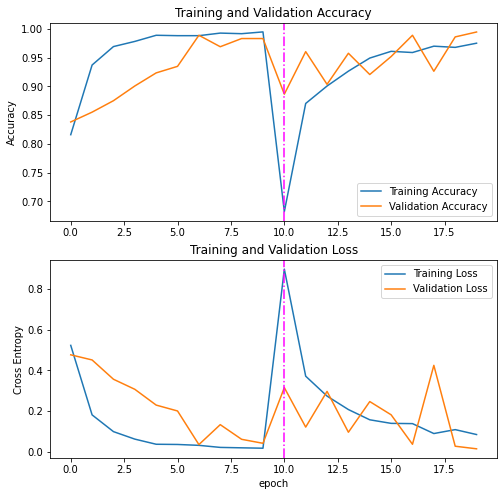

In [ ]:
acc = history.history['accuracy'] + q_aware_history.history['accuracy']
val_acc = history.history['val_accuracy'] + q_aware_history.history['val_accuracy']

loss = history.history['loss'] + q_aware_history.history['loss']
val_loss = history.history['val_loss'] + q_aware_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(10, ls='-.', color='magenta')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(10, ls='-.', color='magenta')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluate model

In [ ]:
_, baseline_model_accuracy = model.evaluate(test)
_, q_aware_model_accuracy = q_aware_model.evaluate(test)

print('Baseline model test accuracy:', baseline_model_accuracy)
print('QAT model test accuracy   :', q_aware_model_accuracy)

367/367 [==============================] - 41s 111ms/step - loss: 0.0149 - accuracy: 0.9946
Baseline model test accuracy: 0.9836512207984924
QAT model test accuracy   : 0.9945504069328308


# Convert Keras model to TF-Lite model

In [ ]:
models_dir = pathlib.Path(os.path.join('.', 'models'))
models_dir.mkdir(exist_ok=True, parents=True)

## TF-Lite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.experimental_new_converter = True
tflite_model = converter.convert()
with open(os.path.join(models_dir, 'mobilenet_v2.tflite'), 'wb') as f:
    f.write(tflite_model)

## Weight quantization model (Post training quantization)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_weight_quant_model = converter.convert()
with open(os.path.join(models_dir, 'mobilenet_v2_weight_quant.tflite'), 'wb') as f:
    f.write(tflite_weight_quant_model)

## Float16 quantization model (Post training quantization)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_fp16_quant_model = converter.convert()
with open(os.path.join(models_dir, 'mobilenet_v2_fp16_quant.tflite'), 'wb') as f:
    f.write(tflite_fp16_quant_model)

## Integer quantization model (Post training quantization)

In [ ]:
def representative_data_gen():
  for batch in test.take(255):
    yield [batch[0]]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_full_integer_quant_model = converter.convert()

with open(os.path.join(models_dir, 'mobilenet_v2_integer_quant.tflite'), 'wb') as f:
    f.write(tflite_full_integer_quant_model)

## Integer quantization model (Quantization aware training)

In [ ]:
#with tfmo.quantization.keras.quantize_scope():
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)

converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_q_aware_integer_quant_model = converter.convert()
with open(os.path.join(models_dir, 'mobilenet_v2_q_aware_integer_quant.tflite'), 'wb') as f:
    f.write(tflite_q_aware_integer_quant_model)

# Save models (keras models)

In [ ]:
# Save keras model
model.save(os.path.join(models_dir, 'mobilenet_v2.h5'))
q_aware_model.save(os.path.join(models_dir, 'mobilenet_v2_quant.h5'))

# Inference TF-Lite model

In [ ]:
def inference_tflite(mode_path, num_test):
  interpreter = tf.lite.Interpreter(model_path=mode_path)

  interpreter.allocate_tensors()
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  print('input_details:  ', interpreter.get_input_details())
  print('output_details: ', interpreter.get_output_details())

  total_seen = 0
  num_correct = 0
  inference_time = []

  for batch in test.take(int(num_test)):
    image = batch[0].numpy()

    start_ms = time.time()

    interpreter.set_tensor(interpreter.get_input_details()[0]["index"], image)
    interpreter.invoke()
    predictions = interpreter.get_tensor(interpreter.get_output_details()[0]["index"])

    elapsed_ms = time.time() - start_ms
    inference_time.append(elapsed_ms * 1000.0)

    if batch[1].numpy() == np.argmax(predictions):
      num_correct += 1
    total_seen += 1

    if total_seen % 50 == 0:
        print("Accuracy after %i images: %f" %
              (total_seen, float(num_correct) / float(total_seen)))

  print('Num images: {0:}, Accuracy: {1:.4f}, Latency: {2:.2f} ms'.format(num_test,
                                                                         float(num_correct / total_seen),
                                                                         np.array(inference_time).mean()))

Evaluate TF-Lite model

In [ ]:
model_path = os.path.join(models_dir, 'mobilenet_v2.tflite')
inference_tflite(model_path, int(num_test))

input_details:   [{'name': 'input_1', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details:  [{'name': 'Identity', 'index': 178, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([1, 5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Accuracy after 50 images: 0.980000
Accuracy after 100 images: 0.980000
Accuracy after 150 images: 0.973333
Accuracy after 200 images: 0.975000
Accuracy after 250 images: 0.980000
Accuracy after 300 images: 0.983333
Accuracy after 350 images: 0.982857
Num images: 36

Evaluate weight quantization model (Post training quantization)

In [ ]:
model_path = os.path.join(models_dir, 'mobilenet_v2_weight_quant.tflite')
inference_tflite(model_path, int(num_test))

input_details:   [{'name': 'input_1', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([  1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details:  [{'name': 'Identity', 'index': 178, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([1, 5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Accuracy after 50 images: 0.860000
Accuracy after 100 images: 0.830000
Accuracy after 150 images: 0.833333
Accuracy after 200 images: 0.840000
Accuracy after 250 images: 0.852000
Accuracy after 300 images: 0.853333
Accuracy after 350 images: 0.854286
Num images: 36

Evaluate Float16 quantization model (Post training quantization)

In [ ]:
model_path = os.path.join(models_dir, 'mobilenet_v2_fp16_quant.tflite')
inference_tflite(model_path, int(num_test))

input_details:   [{'name': 'input_1', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([  1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details:  [{'name': 'Identity', 'index': 178, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([1, 5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Accuracy after 50 images: 0.980000
Accuracy after 100 images: 0.980000
Accuracy after 150 images: 0.973333
Accuracy after 200 images: 0.975000
Accuracy after 250 images: 0.980000
Accuracy after 300 images: 0.983333
Accuracy after 350 images: 0.982857
Num images: 36

Evaluate Integer quantization model (Post training quantization)

In [ ]:
model_path = os.path.join(models_dir, 'mobilenet_v2_integer_quant.tflite')
inference_tflite(model_path, int(num_test))

input_details:   [{'name': 'input_1', 'index': 179, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([  1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details:  [{'name': 'Identity', 'index': 180, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([1, 5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Accuracy after 50 images: 0.980000
Accuracy after 100 images: 0.970000
Accuracy after 150 images: 0.966667
Accuracy after 200 images: 0.970000
Accuracy after 250 images: 0.976000
Accuracy after 300 images: 0.980000
Accuracy after 350 images: 0.977143
Num images: 

Evaluate Integer quantization model (Quantization aware training)

In [ ]:
model_path = os.path.join(models_dir, 'mobilenet_v2_q_aware_integer_quant.tflite')
inference_tflite(model_path, int(num_test))

input_details:   [{'name': 'input_1', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([  1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details:  [{'name': 'Identity', 'index': 180, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([1, 5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Accuracy after 50 images: 0.280000
Accuracy after 100 images: 0.240000
Accuracy after 150 images: 0.273333
Accuracy after 200 images: 0.255000
Accuracy after 250 images: 0.240000
Accuracy after 300 images: 0.256667
Accuracy after 350 images: 0.240000
Num images: 36

# Compile Edge TPU Model



In [ ]:
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
!sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 6A030B21BA07F4FB
!sudo apt update -qq
!sudo apt install edgetpu-compiler

deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Executing: /tmp/apt-key-gpghome.VIzmhu30Oz/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 6A030B21BA07F4FB
gpg: key 6A030B21BA07F4FB: public key "Google Cloud Packages Automatic Signing Key <gc-team@google.com>" imported
gpg: Total number processed: 1
gpg:               imported: 1
65 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libedgetpu1-std
The following NEW packages will be installed:
  edgetpu-compiler libedgetpu1-std
0 upgraded, 2 newly installed, 0 to remove and 65 not upgraded.
Need to get 4,998 kB of archives.
After this operation, 18.2 MB of additional disk space will be used.
Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 libedgetpu1-std amd64 14.0 [306 kB]
Get:2 https://packages.cloud.google.com/apt c

In [ ]:
!edgetpu_compiler -v

Edge TPU Compiler version 2.1.302470888


Compile integer quantization (Post training quantization)

In [ ]:
!edgetpu_compiler -s --out_dir /content/models /content/models/mobilenet_v2_integer_quant.tflite

Edge TPU Compiler version 2.1.302470888

Model compiled successfully in 534 ms.

Input model: /content/models/mobilenet_v2_integer_quant.tflite
Input size: 2.72MiB
Output model: /content/models/mobilenet_v2_integer_quant_edgetpu.tflite
Output size: 2.77MiB
On-chip memory used for caching model parameters: 2.71MiB
On-chip memory remaining for caching model parameters: 4.21MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: /content/models/mobilenet_v2_integer_quant_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 70
Number of operations that will run on CPU: 2

Operator                       Coun

Compile integer quantization (Quantization aware training)

In [ ]:
!edgetpu_compiler -s --out_dir /content/models /content/models/mobilenet_v2_q_aware_integer_quant.tflite

Edge TPU Compiler version 2.1.302470888

Internal compiler error. Aborting! 
